In [258]:
import pickle, math

import h5py
import numpy as np
import scipy as sp
import tensorflow_datasets as tfds

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import seaborn as sns
sns.set_theme(style='ticks', font_scale=1.3)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + [mcolors.to_rgba(mcolors.CSS4_COLORS['lime']), mcolors.to_rgba(mcolors.CSS4_COLORS['sandybrown'])]
sns_blue = sns.color_palette().as_hex()[0]

from src import iris_train

from importlib import reload
reload(iris_train);

In [259]:
iris_ds = tfds.load('iris', split='train', batch_size=-1, shuffle_files=True)

x = iris_ds['features'].numpy()
y = iris_ds['label'].numpy()

x_train, x_test = x[:120], x[120:]
y_train, y_test = y[:120], y[120:]

input_dim = 4
h_dim = 10
output_dim = 3
iho = (input_dim, h_dim, output_dim)

In [260]:
# Style settings

plt.rcParams['text.usetex'] = True

# Small $\eta$

1e-08


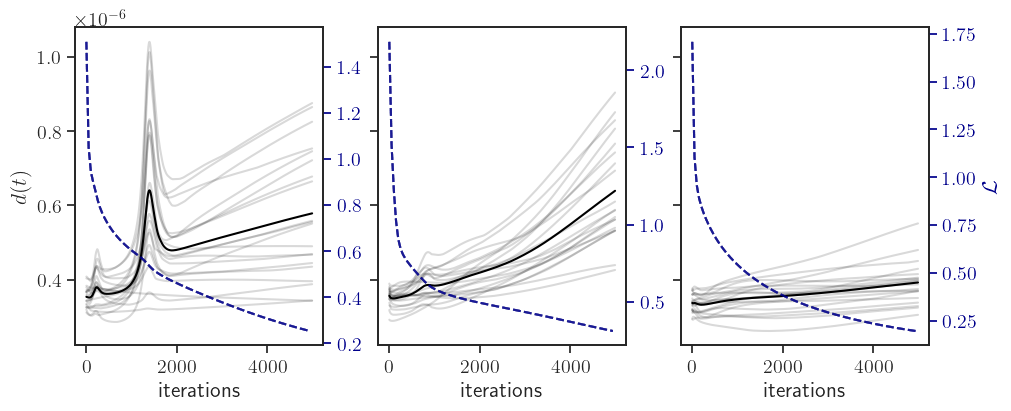

In [6]:
# Example trajectories
with h5py.File('results/epsilon_full.h5', 'r') as f :
    weights_ds = f['weights']
    # loss_ds = f['loss']

    epsilons = f.attrs['epsilons']
    n_init = f.attrs['n_init']

    idx = 10
    print(epsilons[idx])

    ws_8 = weights_ds[idx, ...]
    dists_8 = np.squeeze(iris_train.get_dists_dataset_frommat(ws_8[None, :]), axis=0)
    model = iris_train.get_empty_model(h_dim)
    period = 50
    losses_8 = np.empty((3, f.attrs['n_pert'], f.attrs['n_sample_points']//period))
    for i_init in range(3) :
        for i_pert in range(f.attrs['n_pert']) :
            losses_8[i_init,i_pert] = iris_train.get_loss_from_matrices(ws_8[i_init,i_pert,::period], model, x_train, y_train)

fig, ax = plt.subplots(1, 3, figsize=(10,4), constrained_layout=True, sharey=True)
# fig, ax = plt.subplots(1, 3, figsize=(12,4), constrained_layout=True)

for i_init in range(n_init)[:3] :
    ax[i_init].plot(dists_8[i_init, :, :].T, color='black', alpha=0.15, zorder=4)
    ax[i_init].plot(np.mean(dists_8[i_init, :, :].T, axis=1), color='black', zorder=5)

    ax_ls = ax[i_init].twinx()
    ax_ls.plot(np.arange(0, dists_8.shape[-1], period), losses_8[i_init].T, color='darkblue', ls='--', alpha=0.1)
    ax_ls.tick_params(colors='darkblue', which='both')

    ax[i_init].set_xlabel('iterations')
ax[0].set_ylabel('$d(t)$')
ax_ls.set_ylabel("$\mathcal{L}$", color='darkblue')

plt.savefig('../report/figures/example.pdf')

## 4.2 — Dependence on $\epsilon$

[1.e-14 1.e-10 1.e-06 1.e-02]


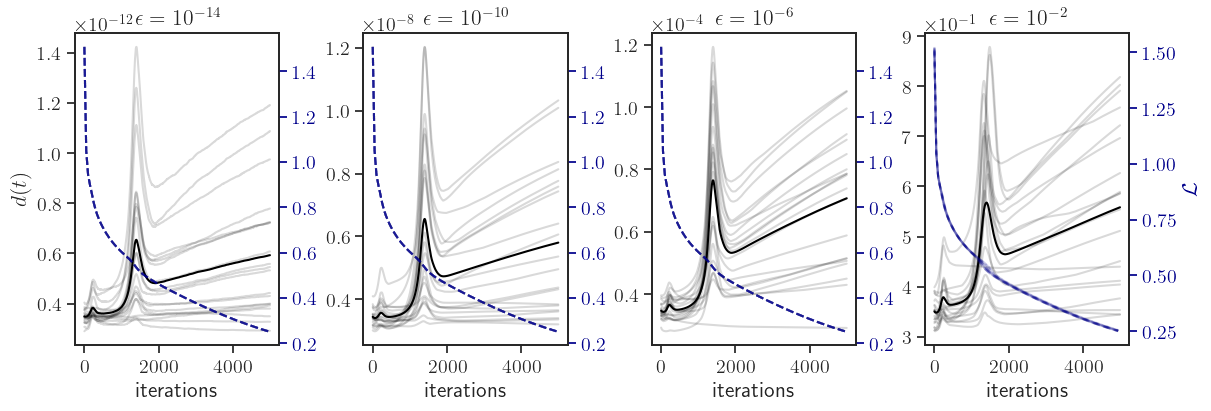

In [7]:
# Different epsilon
with h5py.File('results/epsilon_full.h5', 'r') as f :
    weights_ds = f['weights']

    i_init = 0

    epsilons = f.attrs['epsilons']
    eps_indices = [4, 8, 12, 16]
    print(epsilons[eps_indices])

    ws = weights_ds[eps_indices, i_init, ...]
    dists = np.squeeze(iris_train.get_dists_dataset_frommat(ws[:, None, ...]), axis=1)
    model = iris_train.get_empty_model(h_dim)
    period = 50
    losses = np.empty((len(eps_indices), f.attrs['n_pert'], f.attrs['n_sample_points']//period))
    for i_eps in range(len(eps_indices)) :
        for i_pert in range(f.attrs['n_pert']) :
            losses[i_eps,i_pert] = iris_train.get_loss_from_matrices(ws[i_eps,i_pert,::period], model, x_train, y_train)

fig, axs = plt.subplots(1, len(eps_indices), figsize=(12,4), constrained_layout=True)

for i, i_eps in enumerate(eps_indices) :
    d = dists[i]

    ax = axs[i]
    ax.set_title("  $\epsilon = 10^{" + str(int(math.log10(epsilons[i_eps]))) + "}$  ")

    ax.plot(d.T, color='black', alpha=0.15, zorder=4)
    ax.plot(np.mean(d.T, axis=1), color='black', zorder=5)

    ax.set_xlabel('iterations')
    # ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    ax_ls = ax.twinx()
    ax_ls.plot(np.arange(0, dists.shape[-1], period), losses[i].T, color='darkblue', ls='--', alpha=0.1)
    ax_ls.tick_params(colors='darkblue', which='both')
axs[0].set_ylabel('$d(t)$')
ax_ls.set_ylabel("$\mathcal{L}$", color='darkblue')

plt.savefig('../report/figures/epsilon_difference.pdf')

[1.e-15 1.e-14 1.e-13 1.e-12 1.e-11 1.e-10 1.e-09 1.e-08 1.e-07 1.e-06
 1.e-05 1.e-04 1.e-03 1.e-02]


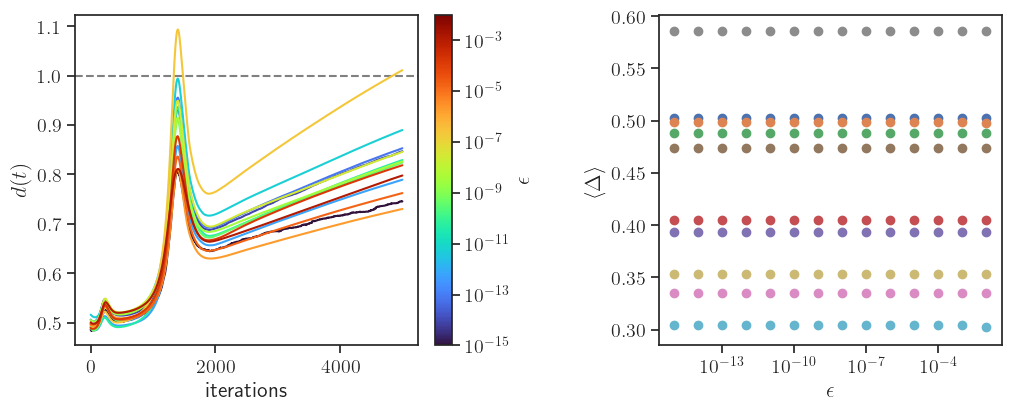

In [43]:
# Normalized by epsilon — distances and displacements
with h5py.File('results/epsilon_full.h5', 'r') as f :
    weights_ds = f['weights']

    n_init = f.attrs['n_init']
    n_pert = f.attrs['n_pert']
    i_init = 0

    epsilons = f.attrs['epsilons']
    # eps_indices = [4, 8, 12, 16]
    eps_indices = range(3, len(epsilons)-5)
    print(epsilons[eps_indices])

    ws = weights_ds[eps_indices, i_init, ...]
    ws_all = weights_ds[eps_indices]
    dists = np.squeeze(iris_train.get_dists_dataset_frommat(ws[:, None, ...]), axis=1)
    # model = iris_train.get_empty_model(h_dim)
    # losses = np.empty((len(eps_indices), f.attrs['n_pert'], f.attrs['n_sample_points']))
    # for i_eps in range(len(eps_indices)) :
    #     for i_pert in range(f.attrs['n_pert']) :
    #         losses[i_eps,i_pert] = iris_train.get_loss_from_matrices(ws[i_eps,i_pert], model, x_train, y_train)

# fig, axs = plt.subplots(1, len(eps_indices), figsize=(12,4), constrained_layout=True)
fig, axs = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True)
fig.set_constrained_layout_pads(wspace=0.1)

norm_factors = 70 * epsilons    # number of neurons * pert radius = max pert distance

cmap = mpl.colormaps['turbo']
norm = mpl.colors.LogNorm(epsilons[eps_indices[0]], epsilons[eps_indices[-1]])

ax = axs[0]
# ax.set_title(f'Average weight trajectories, different $\epsilon$')
for i, i_eps in enumerate(eps_indices) :

    d = dists[i]/norm_factors[i_eps]
    # ax.plot(np.mean(d.T, axis=1), color='black', alpha=0.7, zorder=5)
    ax.plot(np.mean(d.T, axis=1), color=cmap(i/len(eps_indices)), alpha=1, zorder=5)

    ax.set_xlabel('iterations')
    ax.set_ylabel('$d(t)$')

    # ax.twinx().plot(losses[i].T, color='darkblue', ls='--', alpha=0.1)

plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax, label='$\epsilon$')
ax.axhline(1, ls='--', color='gray')

###

ax = axs[1]
# ax.set_title(f'Mean and std of displacements $\Delta$')

for i_init in range(n_init) :
    delta_means = []
    delta_stds = []
    for i, i_eps in enumerate(eps_indices) :
        deltas = []
        for i_pert in range(n_pert+1) :
            ws_pert = ws_all[i,i_init,i_pert]
            w_diff_sum = np.sum(np.abs(ws_pert[-1] - ws_pert[0])) / np.sum(np.abs(ws_pert[0]))     # L1 norm
            deltas.append(w_diff_sum)
        delta_means.append(np.mean(deltas))
        delta_stds.append(np.std(deltas))

    # TODO: Find a better way to visualize stds?

    ax.errorbar(epsilons[eps_indices], delta_means, yerr=delta_stds, ls='', fmt='o')

ax.set_xlabel('$\epsilon$')
ax.set_ylabel('$\langle\Delta\\rangle$')
ax.set_xscale('log')

# plt.subplots_adjust(wspace=2)
plt.savefig('../report/figures/epsilon_norm.pdf')

Check distribution of pairwise distances for above at different points (start, bump, divergence)

/var/folders/17/j4v928fn43lgly2gzf268j480000gn/T/ipykernel_84531/1583606264.py:36: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax_ls.get_shared_y_axes().join(*twins)


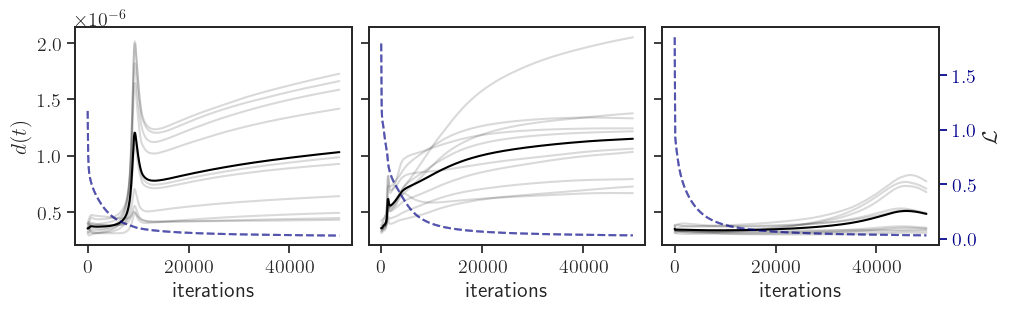

In [41]:
# Long runs
with h5py.File('results/long_run.h5', 'r') as f :
    weights_ds = f['weights']

    epsilon = f.attrs['epsilon']
    N = 70
    d0_exp = N * epsilon / 2

    dists = np.squeeze(iris_train.get_dists_dataset_frommat(np.expand_dims(weights_ds, 0)))

    loss_sample_period = 100
    model = iris_train.get_empty_model(h_dim)
    losses = np.empty((f.attrs['n_init'], f.attrs['n_pert'], f.attrs['n_sample_points']//loss_sample_period))
    for i_init in range(f.attrs['n_init']) :
        for i_pert in range(f.attrs['n_pert']) :
            losses[i_init,i_pert] = iris_train.get_loss_from_matrices(weights_ds[i_init,i_pert,::loss_sample_period], model, x_train, y_train)

    fig, axs = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True, sharey=True)

    twins = []
    for i_init in range(f.attrs['n_init']) :
        ax = axs[i_init]
        d = dists[i_init,:,::loss_sample_period]
        iters = np.arange(0, f.attrs['n_sample_points'], loss_sample_period)

        ax.plot(iters, d.T, color='black', alpha=0.15, zorder=4)
        ax.plot(iters, np.mean(d.T, axis=1), color='black', zorder=5)

        ax.set_xlabel('iterations')

        ax_ls = ax.twinx()
        ax_ls.plot(iters, losses[i_init].T, color='darkblue', ls='--', alpha=0.1)
        ax_ls.tick_params(colors='darkblue', which='both')
        twins.append(ax_ls)
    ax_ls.set_ylabel("$\mathcal{L}$")
    ax_ls.get_shared_y_axes().join(*twins)
    for ax in twins[:-1] : ax.tick_params(right=False, labelright=False, which='both')

    axs[0].set_ylabel('$d(t)$')

    plt.savefig('../report/figures/long_run.pdf')

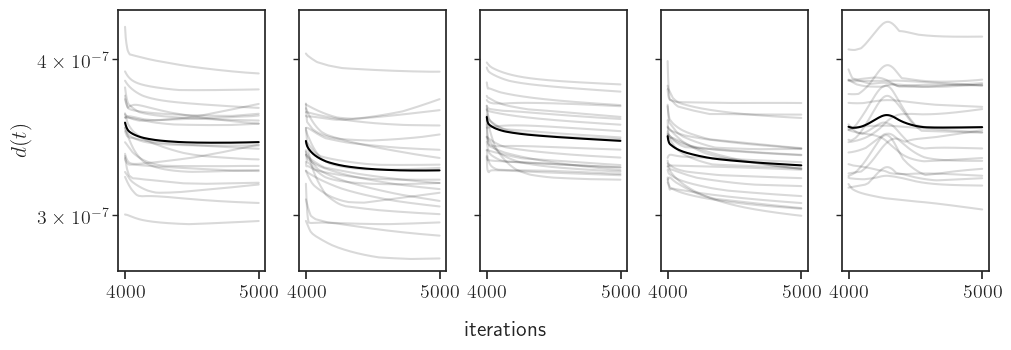

In [90]:
# Post-learning perturbations
with h5py.File('results/post_learn.h5', 'r') as f :
    weights_ds = f['weights']
    # print(dict(f.attrs))
    iters = np.arange(f.attrs['epochs_eff']-f.attrs['post_learn_epochs'], f.attrs['epochs_eff'])

    eps_idx = 10
    dists = np.squeeze(iris_train.get_dists_dataset_frommat(weights_ds[eps_idx,1::2][None,...]))

    loss_sample_period = 10
    # model = iris_train.get_empty_model(h_dim)
    # losses = np.empty((f.attrs['n_init'], f.attrs['n_pert'], f.attrs['n_sample_points']//loss_sample_period))
    # for i_init in range(f.attrs['n_init']) :
    #     for i_pert in range(f.attrs['n_pert']) :
    #         losses[i_init,i_pert] = iris_train.get_loss_from_matrices(weights_ds[i_init,i_pert,::loss_sample_period], model, x_train, y_train)

    
    n_init = f.attrs['n_init'] // 2

fig, axs = plt.subplots(1, n_init, figsize=(10, 3), constrained_layout=True, sharey=True)
fig.set_constrained_layout_pads(wspace=None)

twins = []
for i_init in range(n_init) :
    ax = axs[i_init]
    # d = dists[eps_idx,i_init,:,::loss_sample_period]
    d = dists[i_init,:]
    # iters = np.arange(0, f.attrs['n_sample_points'], loss_sample_period)

    ax.plot(iters, d.T, color='black', alpha=0.15, zorder=4)
    ax.plot(iters, np.mean(d.T, axis=1), color='black', zorder=5)
    # ax.set_xlabel('iterations')

    # ax.set_xscale('log')
    ax.set_yscale('log')

    # ax_ls = ax.twinx()
    # ax_ls.plot(iters, losses[i_init].T, color='darkblue', ls='--', alpha=0.1)
    # ax_ls.tick_params(colors='darkblue', which='both')
    # twins.append(ax_ls)
# ax_ls.set_ylabel("$\mathcal{L}$")
# ax_ls.get_shared_y_axes().join(*twins)
# for ax in twins[:-1] : ax.tick_params(right=False, labelright=False, which='both')

axs[0].set_ylabel('$d(t)$')
fig.text(0.5, -0.1, 'iterations', ha='center')

plt.savefig('../report/figures/epsilon_post_learn.pdf', bbox_inches='tight')

In [61]:
dists.shape

(0, 5, 20, 1000)

## 4.3 — Distance norm

1e-08


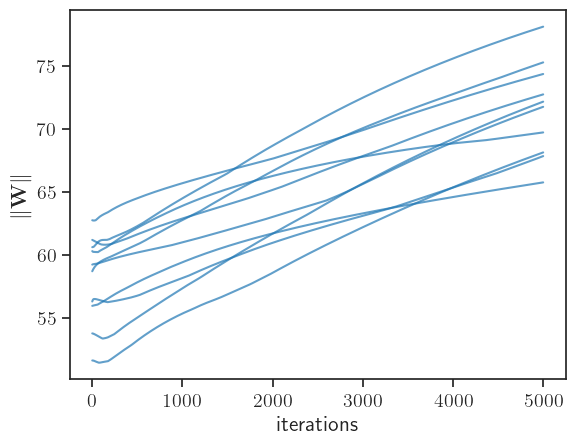

In [65]:
with h5py.File('results/epsilon_full.h5', 'r') as f :
    weights_ds = f['weights']

    i_init = 0

    epsilons = f.attrs['epsilons']
    eps_idx = 10
    print(epsilons[eps_idx])

    ws = weights_ds[eps_idx, :, 0, ...]

    norms = np.sum(np.abs(ws), axis=(-2, -1))

plt.plot(norms.T, color='tab:blue', alpha=0.7);
plt.xlabel('iterations')
plt.ylabel('$\|\mathbf{W}\|$')

plt.savefig('../report/figures/weight_norm.pdf')

## 4.4 — Neutral drift?

/var/folders/17/j4v928fn43lgly2gzf268j480000gn/T/ipykernel_84531/3471292764.py:15: RuntimeWarning: divide by zero encountered in divide
  deltas = np.abs(ws[-1] - ws[0])/np.abs(ws[0])


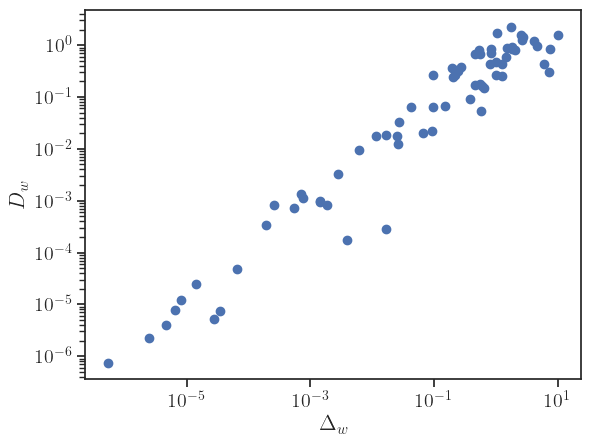

In [67]:
# Weight displacements vs distance
with h5py.File('results/epsilon_full.h5', 'r') as f :
    weights_ds = f['weights']

    i_eps = 10
    i_init = 0

    # fig, axs = plt.subplots(5, 2, figsize=(6, 12))
    
    ws = weights_ds[i_eps,i_init,0]

ws = ws.reshape(ws.shape[0],-1)
ws = ws[:,~np.all(ws == 0, axis=0)]     # Exclude buffer weights
# ax.hist(np.abs(ws[-1] - ws[0]), bins=np.linspace(-2,2,20))
deltas = np.abs(ws[-1] - ws[0])/np.abs(ws[0])
change_total = np.sum(np.abs(ws[1:] - ws[:-1]), axis=0)

plt.scatter(deltas, change_total)
plt.xscale('log')
plt.yscale('log')

plt.xlabel("$\Delta_w$")
plt.ylabel("$D_w$")

# plt.tight_layout()
plt.savefig('../report/figures/weight_delta_dist.pdf')

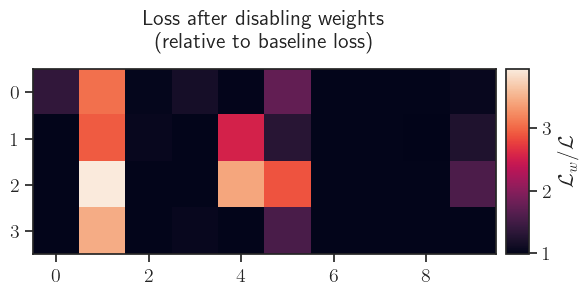

In [24]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Weight "feature importance"
with h5py.File('results/epsilon_full.h5', 'r') as f :
    weights_ds = f['weights']

    i_eps = 10
    i_init = 7

    ws = np.squeeze(iris_train.matrices_to_weights_list(weights_ds[i_eps,i_init,0][None,...], *iho))

model = iris_train.get_empty_model(h_dim)
w_final = ws[-1]
model.set_weights(w_final)
l_baseline = model.loss(y_train, model(x_train)).numpy()

w_id = 0

input_shape = w_final[w_id].shape
l_change = np.empty(input_shape)
for i in range(input_shape[0]) :
    for j in range(input_shape[1]) :
        w = [m.copy() for m in w_final]
        w[w_id][i,j] = 0
        model.set_weights(w)
        l = model.loss(y_train, model(x_train)).numpy()
        l_change[i,j] = l / l_baseline       # Relative to magnitude of baseline loss

im = plt.imshow(l_change)
ax = plt.gca()
ax.set_title(f"Loss after disabling weights \n(relative to baseline loss)", pad=15)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
plt.colorbar(im, cax=cax, label="$\mathcal{L}_w/\mathcal{L}$")
l_baseline

plt.savefig('../report/figures/weight_loss.pdf')

Text(0, 0.5, 'L')

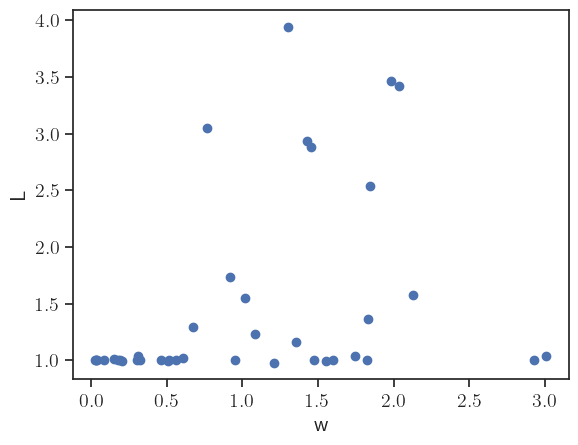

In [82]:
plt.scatter(np.abs(w_final[0].flatten()), l_change.flatten())
plt.xlabel('w')
plt.ylabel('L')

1e-08


/var/folders/17/j4v928fn43lgly2gzf268j480000gn/T/ipykernel_11780/1331545205.py:18: RuntimeWarning: divide by zero encountered in divide
  ax.hist((np.abs(ws[:,-1] - ws[:,0])/np.abs(ws[:,0])).flatten(), bins=np.linspace(0,2,20))


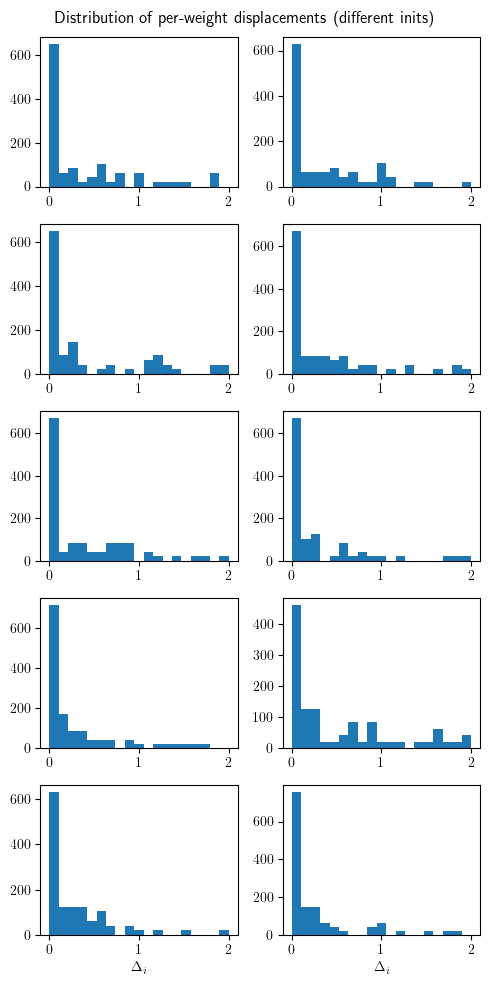

In [110]:
# Distribution of absolute changes (last - first) — "per-weight displacements"
with h5py.File('results/epsilon_full.h5', 'r') as f :
    weights_ds = f['weights']
    # loss_ds = f['loss']

    eps_idx = 10
    print(f.attrs['epsilons'][eps_idx])

    fig, axs = plt.subplots(5, 2, figsize=(5, 10))

    for i, ax in enumerate(axs.flatten()) :
        ws = weights_ds[eps_idx,i]
        ws = ws.reshape(ws.shape[0], ws.shape[1], -1)   # Flatten out weight matrices
        ws = ws[:,:,~np.all(ws == 0, axis=(0,1))]     # Exclude buffer weights
        # vals = (np.abs(ws[:,-1] - ws[:,0])/np.abs(ws[:,0])).flatten()
        # hist, edges = np.histogram(vals, np.linspace(0,2,20))
        # ax.plot(edges[:-1], hist, 'o')
        ax.hist((np.abs(ws[:,-1] - ws[:,0])/np.abs(ws[:,0])).flatten(), bins=np.linspace(0,2,20))
        # ax.set_xscale('log')
        # ax.set_yscale('log')
    
    for ax in axs[-1] : ax.set_xlabel("$\Delta_i$")
    
    fig.suptitle("Distribution of per-weight displacements (different inits)")
    plt.tight_layout()
    plt.savefig('../report/figures/weight_delta.pdf')

# Large $\eta$

## Edge of Stability

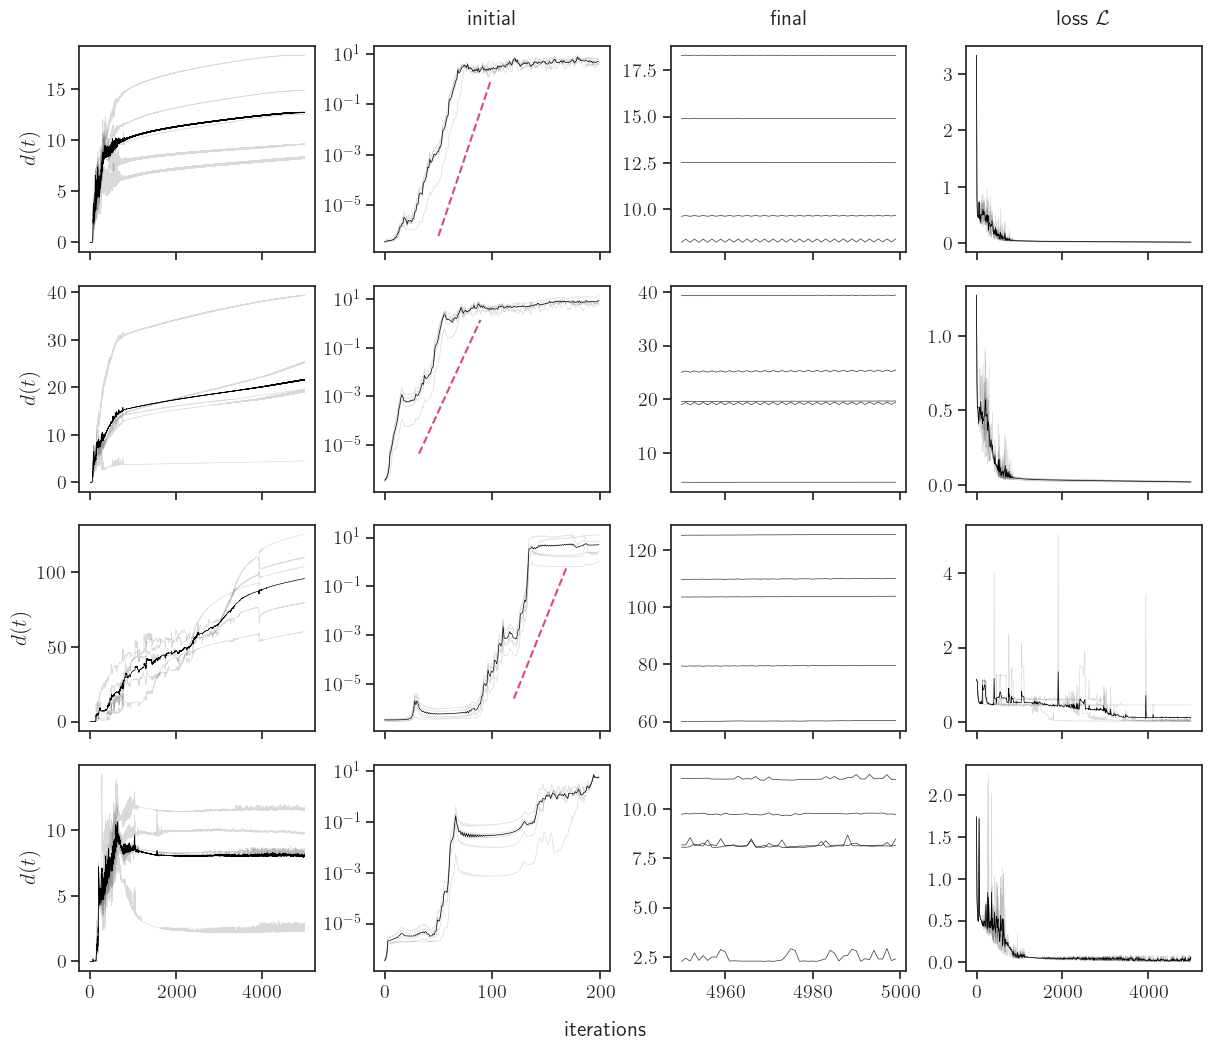

In [219]:
with open('./results/eos_perts.pkl', 'rb') as f :
    ws_chaotic_1 = pickle.load(f)
with open('./results/eos_perts_loss.pkl', 'rb') as f :
    ls_chaotic_1 = pickle.load(f)

dists = np.squeeze(iris_train.get_dists_dataset_frommat(ws_chaotic_1[None, 1::2]))
ls_chaotic_1 = ls_chaotic_1[1::2]

# n_init = ws_chaotic_1.shape[0]
n_init = 4

fit_windows = [
    (20, 70),
    (2, 60),
    (90, 140),
    None
]

fig, axs = plt.subplots(n_init, 4, figsize=(12,n_init*2.5), layout='constrained', sharex='col')
fig.set_constrained_layout_pads(hspace=0.1)

for i_init in range(n_init) :
    ax_row = axs[i_init]
    ax_row[0].plot(dists[i_init].T, lw=0.5, color='black', alpha=0.15)
    ax_row[0].plot(np.mean(dists[i_init], axis=0).T, lw=0.5, color='black')
    ax_row[0].set_ylabel("$d(t)$")

    # ax_row[1].set_title("initial")
    rang = (0, 200)
    d = dists[i_init, :, rang[0]:rang[1]]
    ax_row[1].plot(range(*rang), d.T, lw=0.5, color='black', alpha=0.15)
    ax_row[1].plot(range(*rang), np.mean(d, axis=0).T, lw=0.5, color='black')
    ax_row[1].set_yscale('log')

    fit_window = fit_windows[i_init]
    if fit_window is not None :
        y = np.log(np.mean(d, axis=0))[fit_window[0]:fit_window[1]]
        x = np.arange(*fit_window)
        a, ssr, *_ = np.polyfit(x, y, deg=1, full=True)
        # sst = np.sum((y - np.mean(y))**2)
        ax_row[1].plot(x + 30, np.exp(a[0]*x + a[1]), ls='--', color='#de4968')

    # ax_row[2].set_title("final")
    n_fin = 50
    ax_row[2].plot(range(dists.shape[2]-n_fin, dists.shape[2]), dists[i_init, :, -n_fin:].T, lw=0.5, color='black', alpha=0.8)
    # breakplot = BreakableAxesSubplot(
    #     fig,
    #     axs.shape,
    #     # y_limits=y_limits,
    #     y_breaks=(10, 15),
    #     y_proportion=(3, 1),
    # )
    # breakplot.plot(range(dists.shape[2]-n_fin, dists.shape[2]), dists[i_init, :, -n_fin:].T, lw=0.5)

    # ax_row[3].plot(np.arange(0,5000,10), ls_chaotic_1[i_init].T, lw=0.5)
    ax_row[3].plot(np.arange(0,5000,10), ls_chaotic_1[i_init].T, lw=0.5, color='black', alpha=0.15)
    ax_row[3].plot(np.arange(0,5000,10), np.mean(ls_chaotic_1[i_init], axis=0).T, lw=0.5, color='black')
    # ax_row[3].plot(ls_chaotic_1[i_init, :, 50:150].T, lw=0.5)
    # ax_row[3].set_title("loss $\mathcal{L}$")
    # ax_row[3].set_xscale('log')

axs[0][1].set_title("initial", pad=15)
axs[0][2].set_title("final", pad=15)
axs[0][3].set_title("loss $\mathcal{L}$", pad=15)

fig.text(0.5, -0.03, 'iterations', ha='center')
plt.savefig('../report/figures/eos.png', dpi=160, bbox_inches='tight')

[  0.16849854 -20.83655588]
[0.87147525]


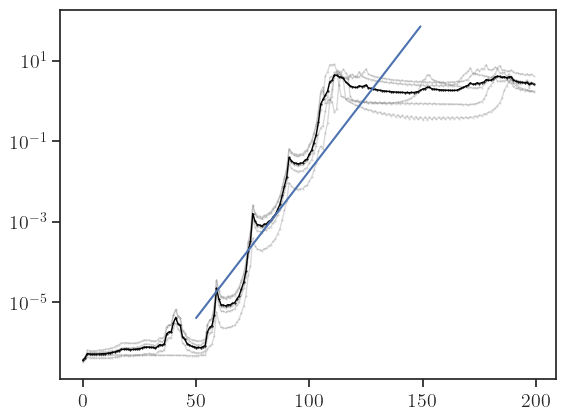

In [206]:
# with open('../src/results/eos_perts.pkl', 'rb') as f :
#     ws_chaotic_1 = pickle.load(f)
# with open('../src/results/eos_perts_loss.pkl', 'rb') as f :
#     ls_chaotic_1 = pickle.load(f)

dists = np.squeeze(iris_train.get_dists_dataset_frommat(ws_chaotic_1[None, :]))
n_init = ws_chaotic_1.shape[0]

i_init = 2
d = dists[i_init,:,:200].T
plt.plot(d, '.-', ms=1, lw=1, color='gray', alpha=0.3);
plt.plot(np.mean(d, axis=1), '.-', ms=1, lw=1, color='black');
plt.yscale('log')
# plt.xscale('log')

fit_window = (50,150)
y = np.log(np.mean(d, axis=1))[fit_window[0]:fit_window[1]]
x = range(*fit_window)
a, ssr, *_ = np.polyfit(x, y, deg=1, full=True)
sst = np.sum((y - np.mean(y))**2)
print(a)

# plt.figure()
plt.plot(x, np.exp(a[0]*x + a[1]))

rsq = 1 - ssr/sst
print(rsq)

/Users/kalo/.pyenv/versions/3.10.8/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kalo/.pyenv/versions/3.10.8/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kalo/.pyenv/versions/3.10.8/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kalo/.pyenv/versions/3.10.8/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/kalo/.pyenv/versions/3.10.8/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.

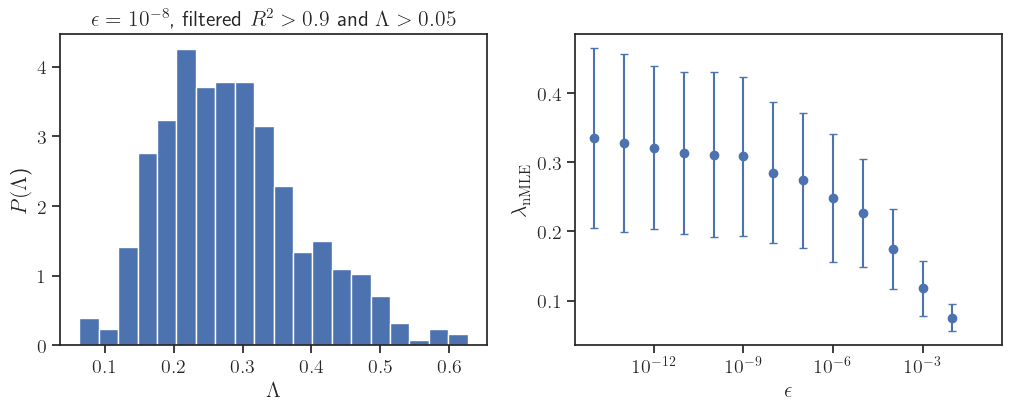

In [261]:
fig, axs = plt.subplots(1, 2, figsize=(10,4), layout='constrained')
fig.set_constrained_layout_pads(wspace=0.05)

step = 5
mins, windows = np.mgrid[0:100+step:step, 30:100+step:step]
maxs = mins + windows

n_init = 500

###

with h5py.File('results/eos_exponent_eps.h5', 'r') as f :
    weights_ds = f['weights']
    epsilons = f.attrs['epsilons']
    dists_eps = iris_train.get_dists_dataset_frommat(weights_ds)

rs = np.empty((len(epsilons), n_init, *mins.shape))
slopes = np.empty((len(epsilons), n_init, *mins.shape))

for i_eps, eps in enumerate(epsilons) :
    dists = dists_eps[i_eps]
    for i in range(mins.shape[0]) :
        for j in range(mins.shape[1]) :
            x1, x2 = mins[i,j], maxs[i,j]
            
            d = np.mean(dists[:, :, x1:x2], axis=1).T
            
            # Do fit of log-norm data
            y = np.log(d)
            x = np.arange(x1,x2)
            a, ssr, *_ = np.polyfit(x, y, deg=1, full=True)
            sst = np.sum((y - np.mean(y, axis=0))**2, axis=0)
            
            rs[i_eps,:,i,j] = 1 - ssr/sst
            slopes[i_eps,:,i,j] = a[0]

best_slopes_idx = np.empty(rs.shape[0:2], dtype=int)     # One (flattened) idx for each init
best_slopes = np.empty(rs.shape[0:2])
best_slopes_r2 = np.empty(rs.shape[0:2])
for i_eps, rs_eps in enumerate(rs) :
    for i_init, rs_init in enumerate(rs_eps) :
        max_r_idx = np.argmax(rs_init)
        best_slopes_idx[i_eps,i_init] = max_r_idx
        best_slopes[i_eps,i_init] = slopes[i_eps,i_init].flatten()[max_r_idx]
        best_slopes_r2[i_eps,i_init] = np.max(rs_init)

r2_threshold = 0.9
slope_threshold = 0.05
best_slopes_filter_val = []
slope_means = []
slope_stds = []
for i_eps, eps in enumerate(epsilons) :
    best_slopes_filter_val.append(best_slopes[i_eps, (best_slopes_r2[i_eps] > r2_threshold) & (best_slopes[i_eps] > slope_threshold)])

    slope_means.append(np.mean(best_slopes_filter_val[i_eps]))
    slope_stds.append(np.std(best_slopes_filter_val[i_eps]))

i_eps = 6
# best_slopes_filter_val = best_slopes[e][(best_slopes_r2[e] > r2_threshold) & (best_slopes[e] > slope_threshold)]
axs[0].hist(best_slopes_filter_val[i_eps], bins=20, density=True);
axs[0].set_xlabel('$\Lambda$');
axs[0].set_ylabel('$P(\Lambda$)');
axs[0].set_title('$\epsilon=10^{-8}$, filtered $R^2>'+str(r2_threshold)+'$ and $\Lambda>'+str(slope_threshold)+'$');

axs[1].errorbar(epsilons, slope_means, slope_stds, fmt='o', capsize=3)
axs[1].set_xscale('log')
axs[1].set_xlabel('$\epsilon$')
axs[1].set_ylabel('$\lambda_\mathrm{nMLE}$')
# axs[1].set_title("$\eta=1$")

plt.savefig('../report/figures/eos_mle.pdf')

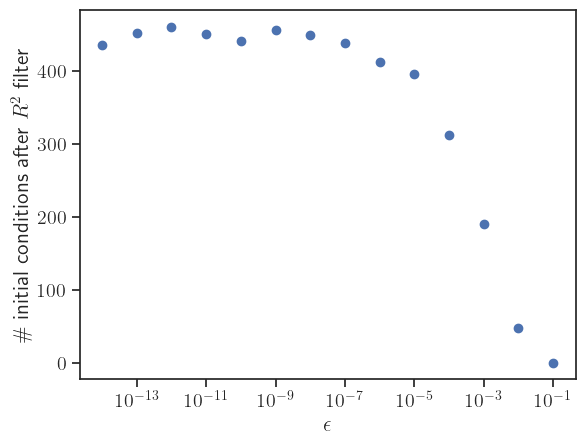

In [378]:
# Number of inits considered after filtering
sizes = []
for i, vals in enumerate(best_slopes_filter_val) :
    # plt.plot(epsilons[i], vals.size)
    sizes.append(vals.size)

plt.plot(epsilons, sizes, 'o')
plt.xscale('log')
plt.xlabel('$\epsilon$')
plt.ylabel('\# initial conditions after $R^2$ filter')

# plt.savefig('../report/figures/eos_mle_filter.pdf')
plt.savefig('../report/figures/eos_mle_filter.png', dpi=300)

## Chaotic-like

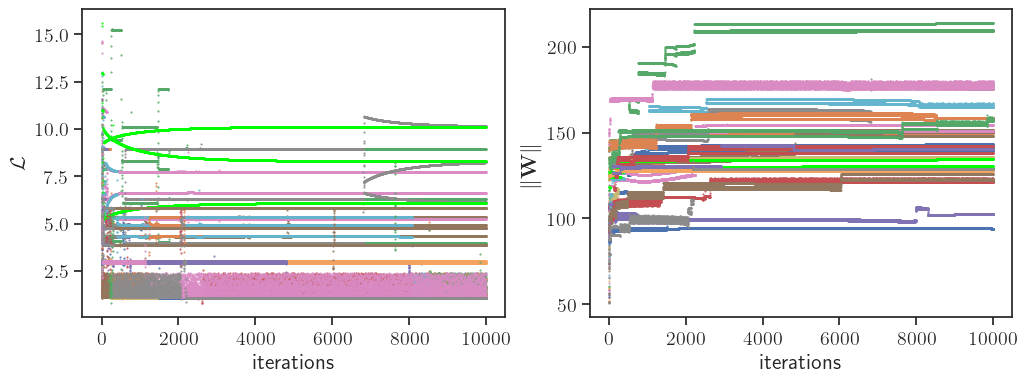

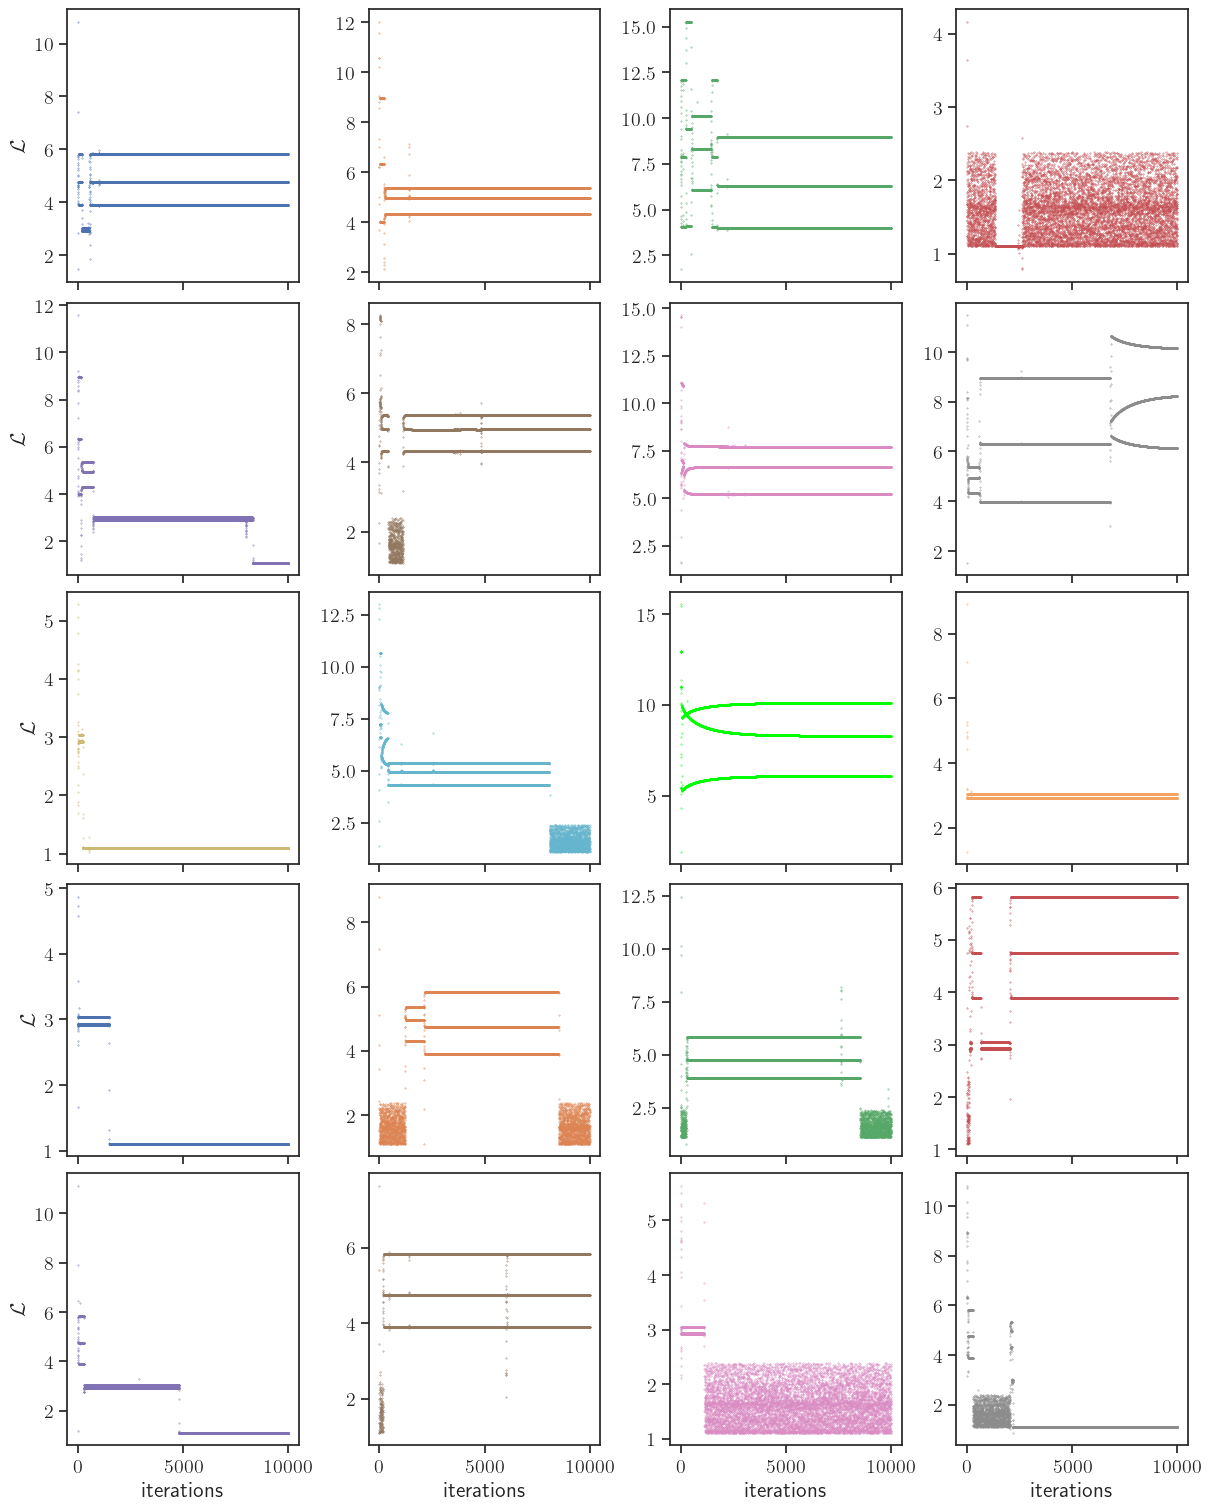

In [5]:
# Original figure from thesis report

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + [mcolors.to_rgba(mcolors.CSS4_COLORS['lime']), mcolors.to_rgba(mcolors.CSS4_COLORS['sandybrown'])]

with h5py.File("results/chaotic.h5") as f :
    weights_ds = f['weights']
    loss_ds = f['loss']

    lr = f.attrs['lr']

    plt.figure(figsize=(12, 4))

    plt.subplot(121)
    for i in range(loss_ds.shape[0]) :
        plt.plot(loss_ds[i].T, 'o', ms=0.5, color=colors[i%len(colors)]);

    # plt.title(f"$\eta={lr}$")
    plt.xlabel("iterations")
    plt.ylabel("$\mathcal{L}$")

    weight_norms = np.sum(np.abs(weights_ds), axis=(-2, -1))

    plt.subplot(122)
    for i in range(loss_ds.shape[0]) :
        plt.plot(weight_norms[i].T, 'o', ms=0.5, color=colors[i%len(colors)]);

    # plt.title(f"$\eta={lr}$, weight norms")
    plt.ylabel("$\|\mathbf{W}\|$")
    plt.xlabel('iterations')

    plt.savefig("../report/figures/chaotic_5.pdf", bbox_inches='tight')

    n_init = f.attrs['n_init']
    cols = 4
    rows = int(np.ceil(n_init / cols))

    fig, axs = plt.subplots(rows, cols, figsize=(12, rows*3), layout='constrained', sharex=True, sharey=False)
    # fig.suptitle(f"$\eta={lr}$")

    axs_flat = axs.flatten()
    for i in range(n_init) :
        axs_flat[i].plot(loss_ds[i].T, 'o', ms=0.3, color=colors[i%len(colors)])

    for ax in axs[-1] : ax.set_xlabel("iterations")
    for ax in axs[:,0] : ax.set_ylabel("$\mathcal{L}$")

    # plt.savefig("../report/figures/chaotic_5_inits_indepy.pdf", bbox_inches='tight')

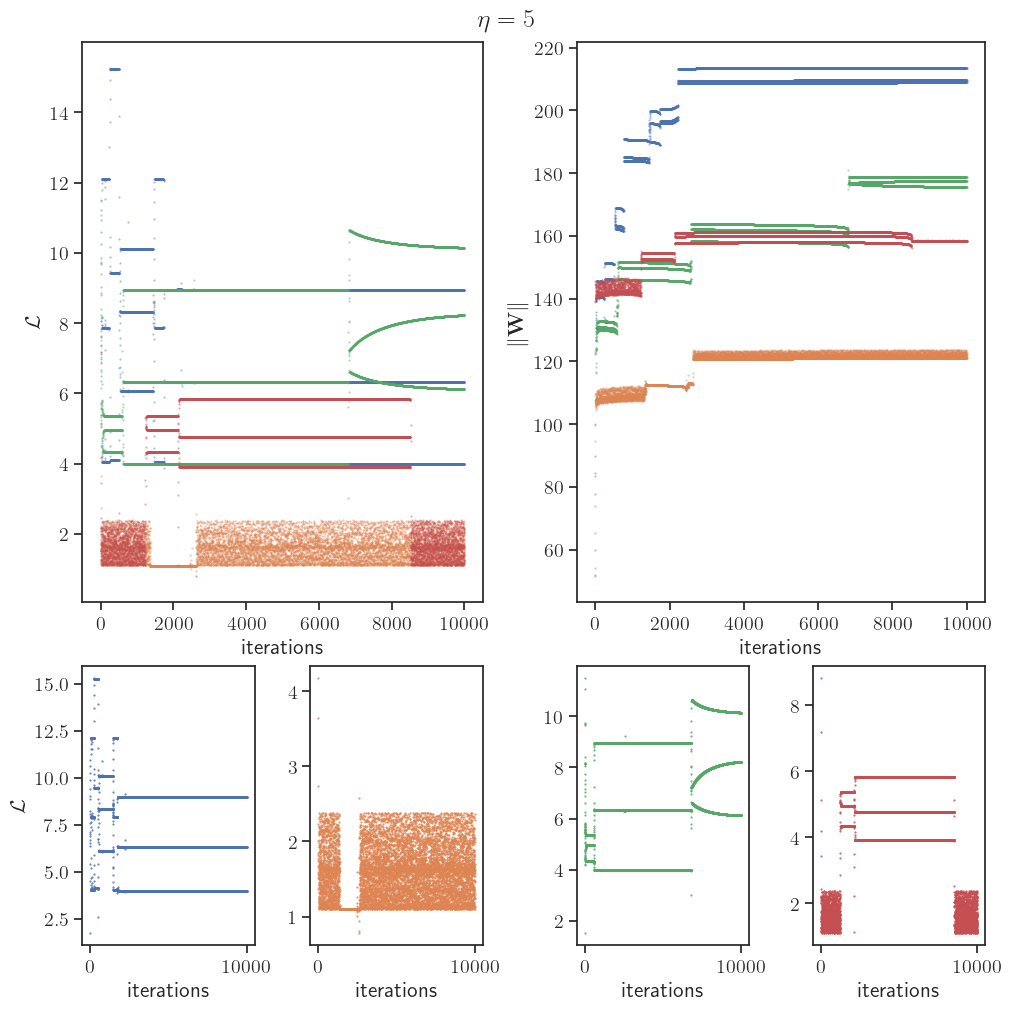

In [14]:
# Pick out "example" trajectories
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + [mcolors.to_rgba(mcolors.CSS4_COLORS['lime']), mcolors.to_rgba(mcolors.CSS4_COLORS['sandybrown'])]

with h5py.File("results/chaotic.h5") as f :
    weights_ds = f['weights']
    loss_ds = f['loss']
    lr = f.attrs['lr']

    inits_idx = [2, 3, 7, 13]   # 12

    ###

    fig = plt.figure(figsize=(10, 10), layout="constrained")
    gs = fig.add_gridspec(3, 4)

    ax_loss = fig.add_subplot(gs[0:2, 0:2])
    ax_norm = fig.add_subplot(gs[0:2, 2:4])

    weight_norms = np.sum(np.abs(weights_ds), axis=(-2, -1))

    for i, idx in enumerate(inits_idx) :
        ax_loss.plot(loss_ds[idx].T, 'o', ms=0.5, alpha = 0.5, color=colors[i])
        ax_norm.plot(weight_norms[idx].T, 'o', ms=0.5, alpha = 0.5, color=colors[i])
    
    ax_loss.set_xlabel("iterations")
    ax_loss.set_ylabel("$\mathcal{L}$")
    
    ax_norm.set_xlabel("iterations")
    ax_norm.set_ylabel("$\|\mathbf{W}\|$")

    axs = [fig.add_subplot(gs[2, i]) for i in range(4)]
    for i in range(4) :
        # ax = fig.add_subplot(gs[2, i])
        axs[i].plot(loss_ds[inits_idx[i]].T, 'o', ms=0.5, color=colors[i])

        axs[i].set_xlabel("iterations")
    axs[0].set_ylabel("$\mathcal{L}$")
    
    fig.suptitle(f"$\eta={lr}$")

    # plt.savefig("../report/figures/chaotic_5_inits_indepy.pdf", bbox_inches='tight')

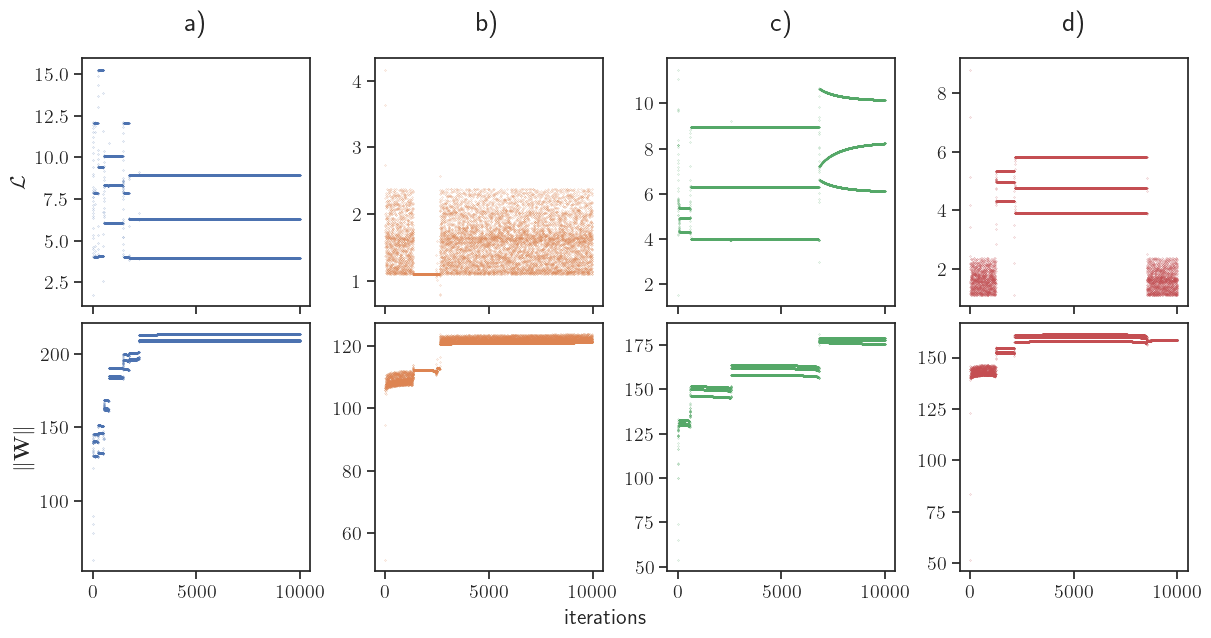

In [410]:
# Pick out "example" trajectories

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + [mcolors.to_rgba(mcolors.CSS4_COLORS['lime']), mcolors.to_rgba(mcolors.CSS4_COLORS['sandybrown'])]

with h5py.File("results/chaotic.h5") as f :
    weights_ds = f['weights']
    loss_ds = f['loss']
    lr = f.attrs['lr']

    inits_idx = [2, 3, 7, 13]   # 12

    ###

    fig = plt.figure(figsize=(12, 6), layout="constrained")
    gs = fig.add_gridspec(2, 4)
    axs = gs.subplots(sharex='col') 

    # axs_loss = [fig.add_subplot(gs[0, i]) for i in range(4)]
    axs_loss = axs[0,:]
    # axs_norm = [fig.add_subplot(gs[1, i]) for i in range(4)]
    axs_norm = axs[1,:]


    for i, ax in enumerate(axs_loss) :
        ax.plot(loss_ds[inits_idx[i]].T, '.', ms=0.3, color=colors[i])
        # ax.set_xlabel("iterations")
        ax.set_title(f"{chr(97+i)})", pad=20, size=20)
    axs_loss[0].set_ylabel("$\mathcal{L}$")

    weight_norms = np.sum(np.abs(weights_ds), axis=(-2, -1))

    for i, ax in enumerate(axs_norm) :
        ax.plot(weight_norms[inits_idx[i]].T, '.', ms=0.3, color=colors[i])
        # ax.set_xlabel("iterations")
    axs_norm[0].set_ylabel("$\|\mathbf{W}\|$")

    fig.text(0.5, -0.03, 'iterations', ha='center')
    plt.savefig("../report/figures/chaotic_inits.png", dpi=200, bbox_inches='tight')

### ACF

In [240]:
# Define and calculate autocorrelation

def get_acf(x) :
    n = len(x)
    mean = np.mean(x)
    var = np.var(x)

    # Compute autocovariance function
    x_norm = x - mean
    autocov = np.correlate(x_norm, x_norm, 'full')[n-1:]
    autocov = autocov / (n - np.arange(n))

    # Compute autocorrelation function
    acf = autocov / var

    return acf

def autocorr_ci(x, n_shuffle=100, CI=0.03):
    """
    Compute autocorrelation function of a time series and confidence intervals for a null model obtained by shuffling.

    Adapted from code by Lucas.
    """
    n = len(x)

    acf = get_acf(x)

    # Shuffle time series and compute autocorrelation function for each shuffle
    acf_null = np.zeros((n_shuffle, n))
    for i in range(n_shuffle):
        xx=x.copy()
        np.random.shuffle(xx)
        acf_null[i, :] = get_acf(xx)

    # Compute confidence intervals for null model
    ci_null = np.zeros((n, 2))
    for i in range(n):
        sorted_null = np.sort(acf_null[:, i])
        # Not ideal but close enough...
        ci_null[i,0] = sorted_null[int(n_shuffle*CI)]
        ci_null[i,1]  = sorted_null[int(n_shuffle*(1-CI))]
    
    return acf, ci_null

with h5py.File("results/chaotic.h5") as f :
    loss_ds = f['loss']
    x = loss_ds[3, 3000:]

    x_norm = x - np.mean(x)
    corr, ci = autocorr_ci(x_norm, n_shuffle=1000, CI=0.03)

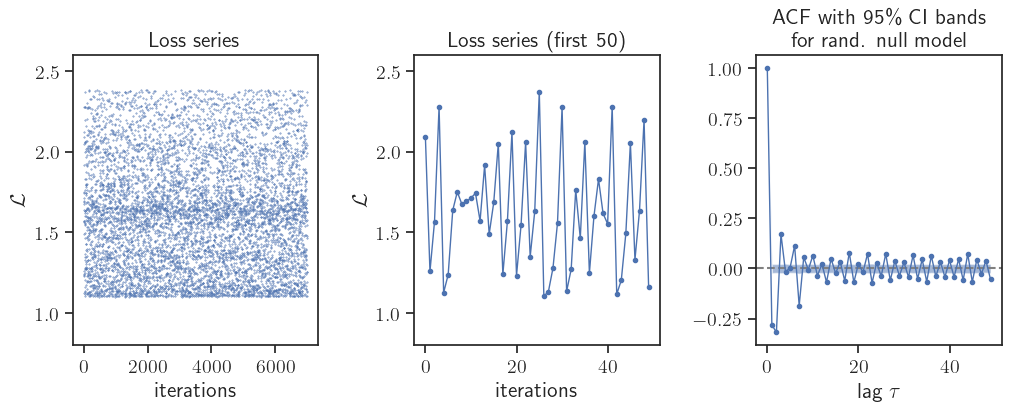

In [252]:
# Plot series and ACF

fig, axs = plt.subplots(1, 3, figsize=(10,4), layout='constrained')
fig.get_layout_engine().set(wspace=0.1)

axs = axs.flatten()

axs[0].set_title("Loss series")
axs[0].plot(x, '.', ms=0.7)
axs[0].set_xlabel('iterations')
axs[0].set_ylabel('$\mathcal{L}$')
axs[0].set_ylim(0.8, 2.6)

lim = 50
axs[1].set_title(f'Loss series (first {lim})')
axs[1].plot(x[:lim], '.-', lw=1)
axs[1].set_xlabel('iterations')
axs[1].set_ylabel('$\mathcal{L}$')
axs[1].set_ylim(*axs[0].get_ylim())

lim = 50
axs[2].set_title('ACF with 95\% CI bands\n for rand. null model')
axs[2].axhline(0, ls='--', color='gray')
axs[2].fill_between(range(lim), ci[:lim,0], ci[:lim,1], alpha=0.5)
axs[2].plot(corr[:lim], '.-', lw=1);
axs[2].set_xlabel('lag $\\tau$')

# plt.savefig('../report/figures/chaotic_acf.pdf', bbox_inches='tight')
plt.savefig('../report/figures/chaotic_acf.png', dpi=160, bbox_inches='tight')

# plt.savefig('../report/figures/chaotic_acf_and_diverge.png', dpi=100, bbox_inches='tight')

### Expansion rates

In [25]:
# Sample initial conditions for calculating local expansion rates

with h5py.File('results/chaotic_inter.h5', 'r') as f :
    loss_ds = f['loss']

    # x for long, chaotic-like trajectory
    x = loss_ds[2700:45000]

rng = np.random.default_rng(1)
n_sample = 1000     # Number of initial conditions to sample
while True :
    p0s_idx = rng.integers(0, x.shape[0], n_sample)
    if len(np.unique(p0s_idx)) == n_sample : break
p0s = x[p0s_idx]

e = 5e-5    # Range for extracting perturbations
p1s_idx = []
x_idx = np.arange(len(x))
for p0 in p0s_idx :
    p1s_idx.append(x_idx[(x < x[p0]+e) & (x > x[p0]-e) & (x != x[p0])])

trajectories = []   # All trajectories in tuples (initial_trajectory, pert_trajectory_list)
for i in range(n_sample) :
    p0_traj = x[p0s_idx[i]:]
    p1s_traj = []
    for p1 in p1s_idx[i] :
        p1s_traj.append(x[p1:])
    
    trajectories.append((p0_traj, p1s_traj))

# Extract individual trajectory
# p0_idx = 16
# t1 = trajectories[p0_idx][0]
# t2s = trajectories[p0_idx][1]

In [130]:
# Fitting and null-model procedure
w_fixed = 10

r2s_fixed = np.empty(n_sample)
slopes_fixed = np.empty(n_sample)
intercepts_fixed = np.empty(n_sample)
ps_fixed = np.empty(n_sample)

# Loop over initial conditions
for i_pt in range(n_sample) :
    # Extract trajectories
    t1 = trajectories[i_pt][0]
    t2s = trajectories[i_pt][1]

    # Calculate average distances to initial condition
    lim = w_fixed + 1
    ds = np.zeros(lim)
    for t2 in t2s :
        # Ensure same length series by padding
        n_max = max(len(t1), len(t2))
        t1 = np.pad(t1, (0, n_max-len(t1)), mode='constant', constant_values=None)
        t2 = np.pad(t2, (0, n_max-len(t2)), mode='constant', constant_values=None)
        
        # Average distances
        d = np.abs(t1 - t2)[:lim]
        ds += d
    ds /= len(t2s)

    # Fit to average distance
    d = ds[1:]    # Exclude first step
    assert d.size == w_fixed

    # Do fit of log-norm data
    y = np.log(d)
    x = np.arange(1, w_fixed+1)

    # a, ssr, *_ = np.polyfit(x, y, deg=1, full=True)
    # sst = np.sum((y - np.mean(y, axis=0))**2, axis=0)
    # rs_fixed[i_pt] = 1 - ssr/sst
    # slopes_fixed[i_pt] = a[0]
    # intercepts_fixed[i_pt] = a[1]
    
    slope, intercept, r, p, _ = sp.stats.linregress(x, y)
    r2s_fixed[i_pt] = r**2
    slopes_fixed[i_pt] = slope
    intercepts_fixed[i_pt] = intercept
    ps_fixed[i_pt] = p

# Categorize inits based on p-value
inits_idx_null = np.where(ps_fixed > 0.05)[0]   # Initial conditions for which null hypothesis is likely (p > 0.05) 
inits_idx_alt = np.where(ps_fixed <= 0.05)[0]    # Initial conditions for which null hypothesis is unlikely (p < 0.05)

/var/folders/17/j4v928fn43lgly2gzf268j480000gn/T/ipykernel_42239/4059411829.py:27: RuntimeWarning: invalid value encountered in divide
  ds /= len(t2s)


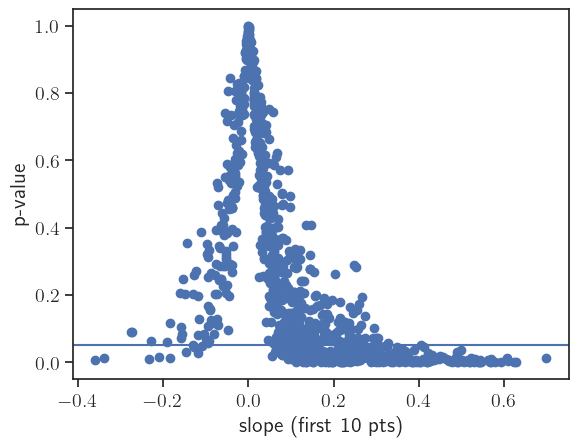

In [132]:
plt.scatter(slopes_fixed, ps_fixed)
plt.xlabel('slope (first 10 pts)')
plt.ylabel('p-value')
plt.axhline(0.05)

/var/folders/17/j4v928fn43lgly2gzf268j480000gn/T/ipykernel_42239/1815586873.py:22: RuntimeWarning: invalid value encountered in divide
  ds /= len(t2s)


Text(0, 0.5, 'value of initial point')

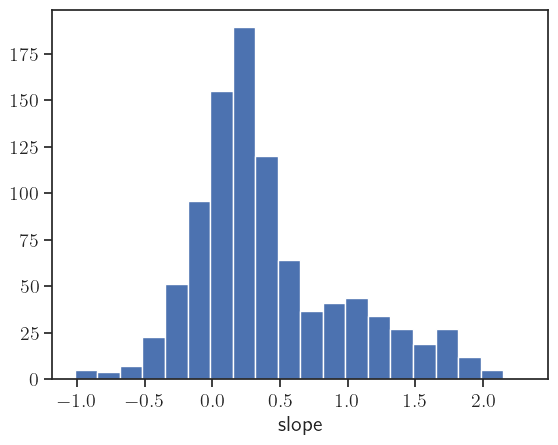

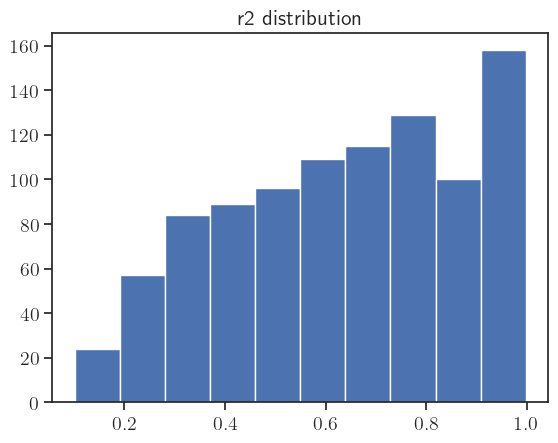

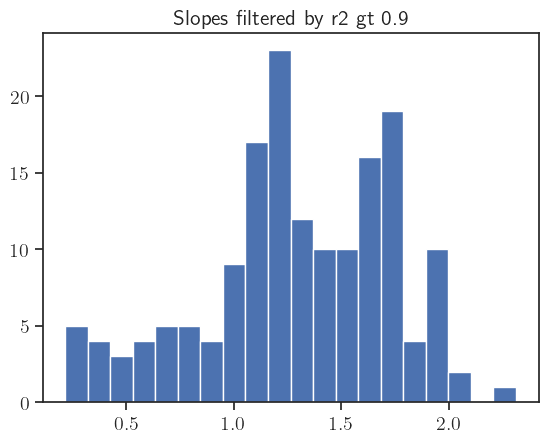

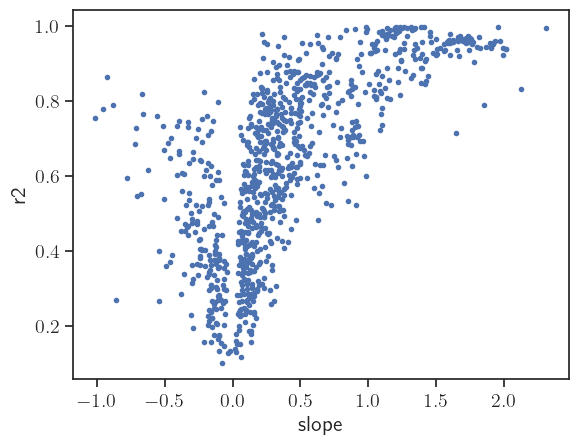

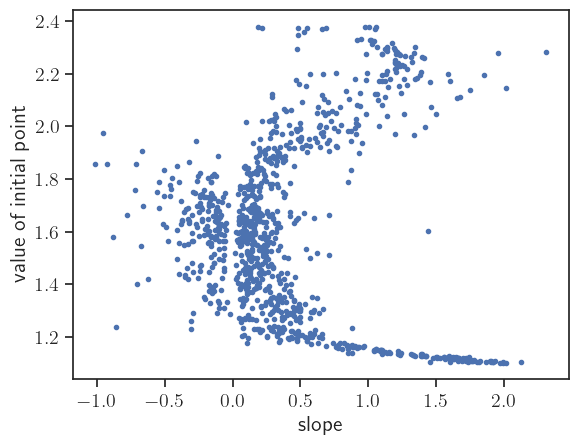

In [143]:
# Calculate best fit slopes for all initial conditions
step = 1
maxs = np.arange(5, 25+step, step)

r2s = np.empty((n_sample, maxs.size))
slopes = np.empty((n_sample, maxs.size))
intercepts = np.empty((n_sample, maxs.size))

for i_pt in range(n_sample) :
    t1 = trajectories[i_pt][0]
    t2s = trajectories[i_pt][1]

    # Single point distances
    lim = 25
    ds = np.zeros(lim)
    for t2 in t2s :
        n_max = max(len(t1), len(t2))
        t1 = np.pad(t1, (0, n_max-len(t1)), mode='constant', constant_values=None)
        t2 = np.pad(t2, (0, n_max-len(t2)), mode='constant', constant_values=None)
        d = np.abs(t1 - t2)[:lim]
        ds += d
    ds /= len(t2s)

    # Fit to average distance
    for i, m in enumerate(maxs) :
        d = ds[1:m]

        # Do fit of log-norm data
        y = np.log(d)
        x = np.arange(1,m)

        a, ssr, *_ = np.polyfit(x, y, deg=1, full=True)
        sst = np.sum((y - np.mean(y, axis=0))**2, axis=0)
        r2s[i_pt,i] = 1 - ssr/sst
        slopes[i_pt,i] = a[0]
        intercepts[i_pt,i] = a[1]
        
        slope, intercept, r, p, _ = sp.stats.linregress(x, y)
        r2s[i_pt,i] = r**2
        slopes[i_pt,i] = slope
        intercepts[i_pt,i] = intercept

# Extract data for best slope fits
best_slopes_idx = np.empty(n_sample, dtype=int)     # One (flattened) idx for each sampled point
best_slopes = np.empty(n_sample)
best_slopes_int = np.empty(n_sample)
best_slopes_r2 = np.empty(n_sample)
for i_pt, r2s_pt in enumerate(r2s) :
    max_r2_idx = np.argmax(r2s_pt)
    best_slopes_idx[i_pt] = max_r2_idx
    best_slopes[i_pt] = slopes[i_pt].flatten()[max_r2_idx]
    best_slopes_int[i_pt] = intercepts[i_pt].flatten()[max_r2_idx]
    best_slopes_r2[i_pt] = np.max(r2s_pt)

r2_threshold = 0.9
# slope_threshold = 0.05
# best_slopes_filter_val = []
# slope_means = []
# slope_stds = []
# for i_eps, eps in enumerate(epsilons) :
    # best_slopes_filter_val.append(best_slopes[i_eps, (best_slopes_r2[i_eps] > r2_threshold) & (best_slopes[i_eps] > slope_threshold)])
best_slopes_filter_val = best_slopes[(best_slopes_r2 > r2_threshold)]

#     slope_means.append(np.mean(best_slopes_filter_val[i_eps]))
#     slope_stds.append(np.std(best_slopes_filter_val[i_eps]))


plt.hist(best_slopes, bins=20)
plt.xlabel('slope')
plt.figure()
plt.hist(best_slopes_r2);
plt.title("r2 distribution");
plt.figure()
plt.hist(best_slopes_filter_val, bins=20);
plt.title("Slopes filtered by r2 gt 0.9");
plt.figure()
plt.plot(best_slopes, best_slopes_r2, '.');
plt.xlabel('slope')
plt.ylabel('r2')
plt.figure()
plt.plot(best_slopes, p0s, '.')
plt.xlabel('slope')
plt.ylabel('value of initial point')

Text(0, 0.5, 'initial condition')

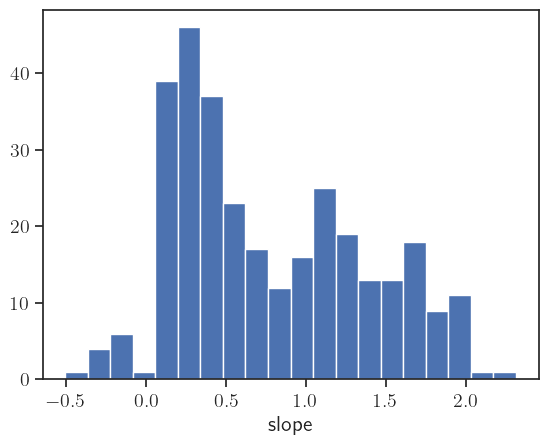

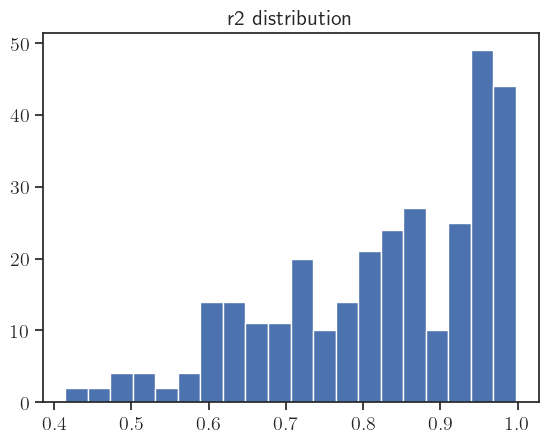

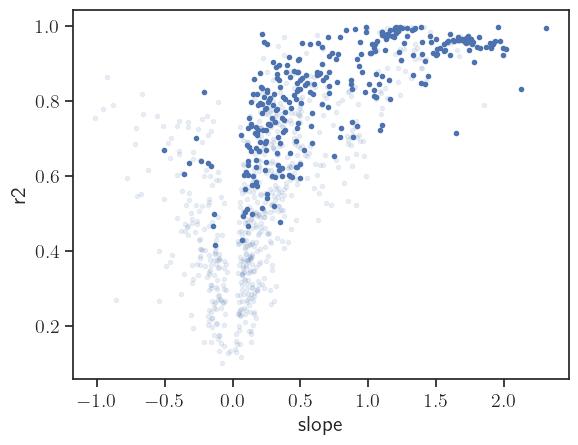

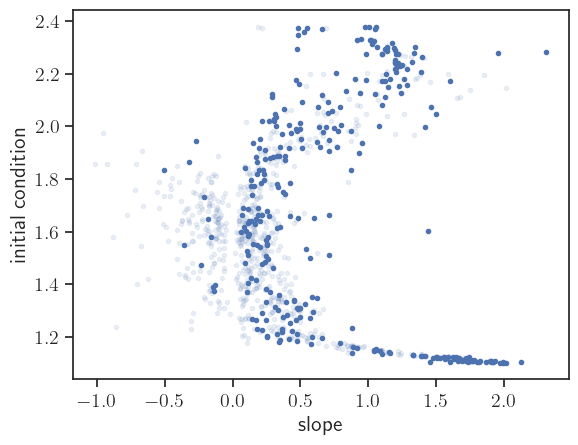

In [168]:
# Distributions for relevant initial conditions (satisfy alt hyp)
plt.hist(best_slopes[inits_idx_alt], bins=20)
plt.xlabel('slope')
plt.figure()
plt.hist(best_slopes_r2[inits_idx_alt], bins=20);
plt.title("r2 distribution");
plt.figure()
plt.plot(best_slopes[inits_idx_null], best_slopes_r2[inits_idx_null], '.', color=sns_blue, alpha=0.1);
plt.plot(best_slopes[inits_idx_alt], best_slopes_r2[inits_idx_alt], '.');
plt.xlabel('slope')
plt.ylabel('r2')
plt.figure()
plt.plot(best_slopes[inits_idx_null], p0s[inits_idx_null], '.', color=sns_blue, alpha=0.1)
plt.plot(best_slopes[inits_idx_alt], p0s[inits_idx_alt], '.')
plt.xlabel('slope')
plt.ylabel('initial condition')

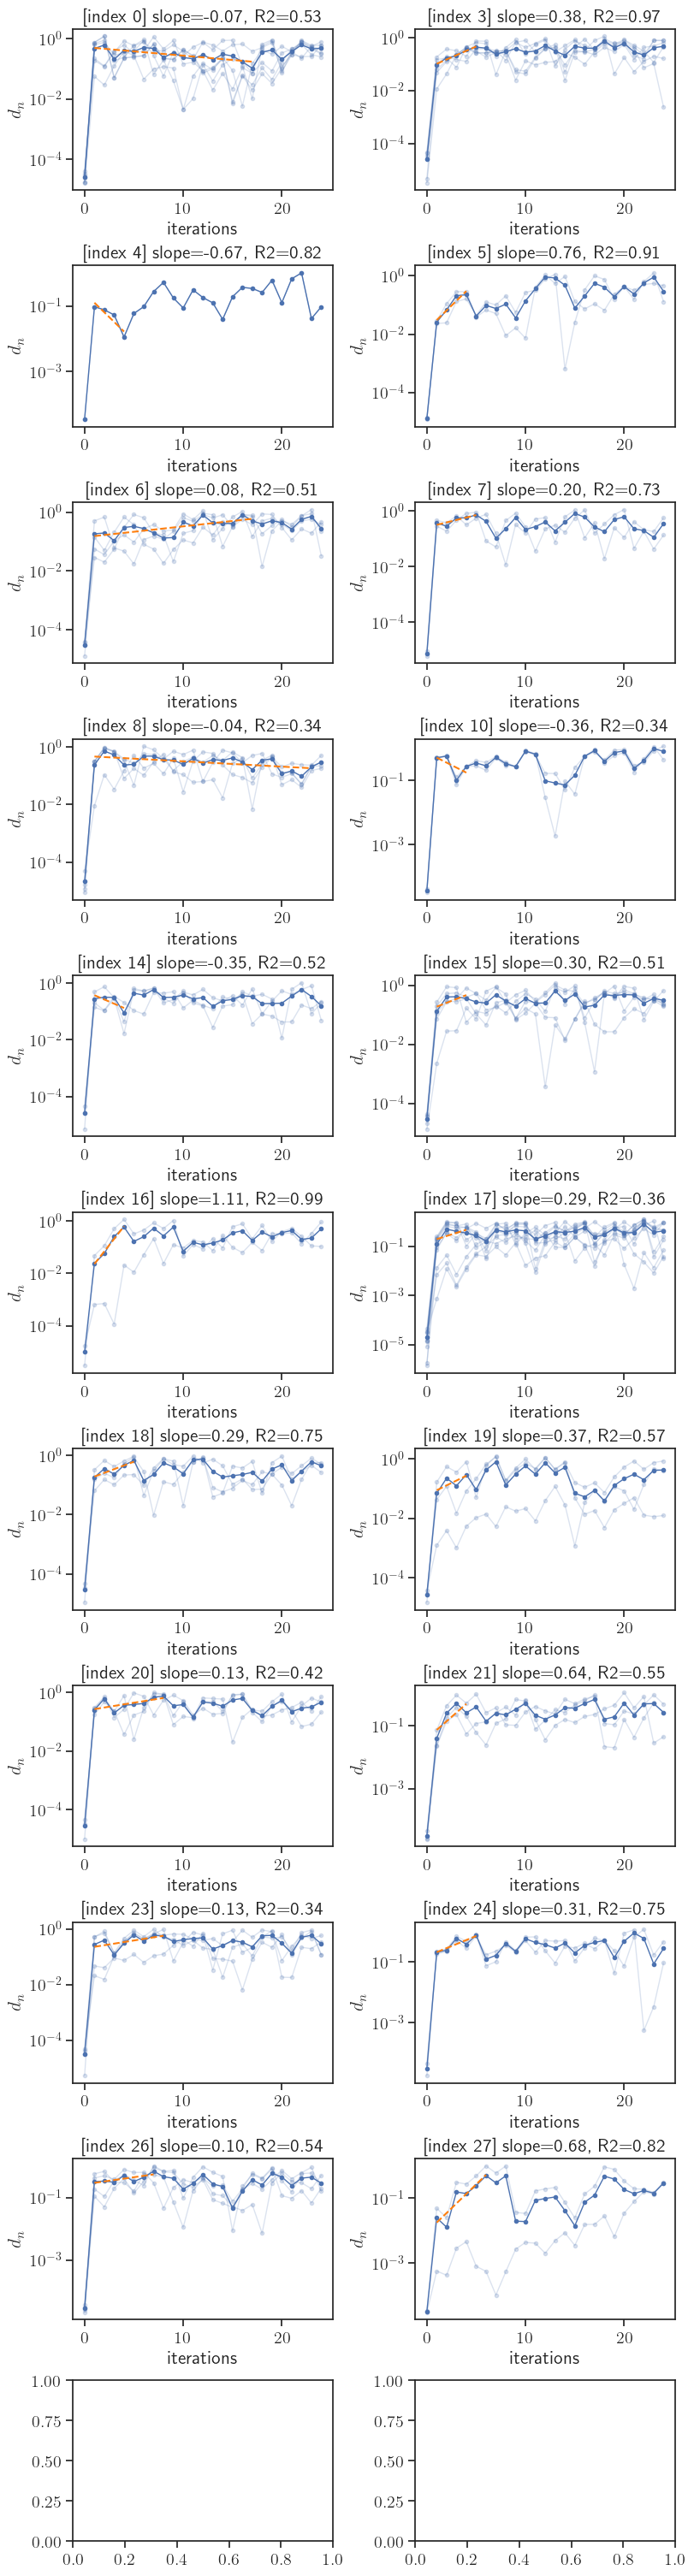

In [157]:
# Plot for multiple points
p0s_idx = [
    np.nanargmax(best_slopes), np.nanargmin(best_slopes), 
    0, 1, 2, 3, 11, 16, 47
]

p0s_idx = inits_idx_null[:20]

cols = 2
fig, axs = plt.subplots(
    1 + len(p0s_idx)//cols, cols,
    figsize=(4 * cols, 3 * len(p0s_idx)//cols), layout='constrained'
)
axs_flat = axs.flatten()

for i, p0 in enumerate(p0s_idx) :
    ax = axs_flat[i]
    
    t1 = trajectories[p0][0]
    t2s = trajectories[p0][1]

    lim = 25
    ds = np.zeros(lim)
    for t2 in t2s :
        n_max = max(len(t1), len(t2))
        t1 = np.pad(t1, (0, n_max-len(t1)), mode='constant', constant_values=None)
        t2 = np.pad(t2, (0, n_max-len(t2)), mode='constant', constant_values=None)
        # distance = t1 - t2
        d = np.abs(t1 - t2)[:lim]
        ds += d
        ax.plot(d, '.-', lw=1, color='#4c72b0', alpha=0.2)

    ax.plot(ds/len(t2s), '.-', lw=1, color='#4c72b0');

    # plot slope of best fit
    wmin = 1
    wmax = maxs[best_slopes_idx[p0]]
    slope = best_slopes[p0]
    intercept = best_slopes_int[p0]
    r2 = best_slopes_r2[p0]
    x = range(wmin, wmax)
    ax.plot(x, np.exp(intercept + slope * x), ls='--', color='tab:orange')

    ax.set_yscale('log')
    ax.set_xlabel("iterations")
    ax.set_ylabel("$d_n$")

    ax.set_title(f'[index {p0}] slope={slope:.2f}, R2={r2:.2f}')

In [255]:
sns_gray = sns.color_palette().as_hex()[7]
sns_orange = sns.color_palette().as_hex()[1]
sns.color_palette().as_hex()

['#4c72b0',
 '#dd8452',
 '#55a868',
 '#c44e52',
 '#8172b3',
 '#937860',
 '#da8bc3',
 '#8c8c8c',
 '#ccb974',
 '#64b5cd']

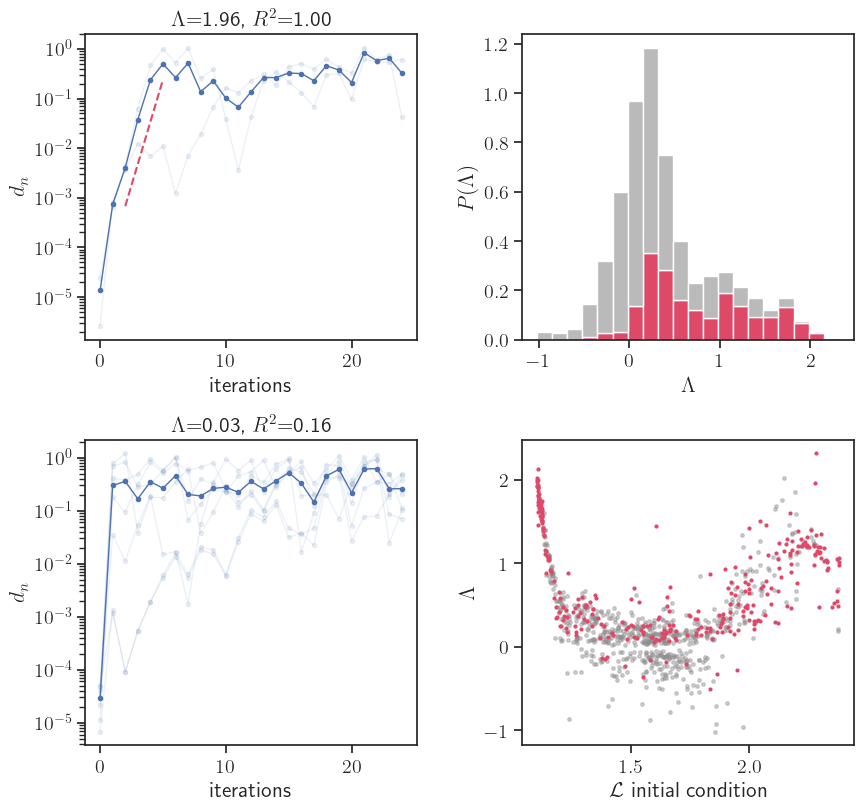

In [256]:
# Plot for multiple points
p0s_idx = [
    # 587, 105
    401, 105
]

fig = plt.figure(figsize=(12, 8), layout="constrained")
gs = fig.add_gridspec(2, 3)
fig.get_layout_engine().set(wspace=0.1, hspace=0.05)

ax_1 = fig.add_subplot(gs[0, 0])
ax_2 = fig.add_subplot(gs[1, 0], sharex=ax_1)
axs = [ax_1, ax_2]
ax_hist = fig.add_subplot(gs[0, 1])
ax_scatter = fig.add_subplot(gs[1, 1])

for i, p0 in enumerate(p0s_idx) :
    ax = axs[i]
    
    t1 = trajectories[p0][0]
    t2s = trajectories[p0][1]

    lim = 25
    ds = np.zeros(lim)
    for t2 in t2s :
        n_max = max(len(t1), len(t2))
        t1 = np.pad(t1, (0, n_max-len(t1)), mode='constant', constant_values=None)
        t2 = np.pad(t2, (0, n_max-len(t2)), mode='constant', constant_values=None)
        # distance = t1 - t2
        d = np.abs(t1 - t2)[:lim]
        ds += d
        ax.plot(d, '.-', lw=1, color='#4c72b0', alpha=0.1)
    ds /= len(t2s)
    ax.plot(ds, '.-', lw=1, color='#4c72b0');

    # Plot best fit for exponential initial condition
    if i == 0 :
    #     fit_window = fit_windows[i_init]
    # if fit_window is not None :
    #     y = np.log(np.mean(d, axis=0))[fit_window[0]:fit_window[1]]
    #     x = np.arange(*fit_window)

        fit_window = (1, maxs[best_slopes_idx[p0]])
        x = np.arange(*fit_window)
        y = np.log(ds)[fit_window[0]:fit_window[1]]
        ax.plot(x + 1, np.exp(best_slopes[p0]*x + best_slopes_int[p0]), ls='--', color='#de4968')

    slope = best_slopes[p0]
    r2 = best_slopes_r2[p0]

    ax.set_yscale('log')
    ax.set_xlabel("iterations")
    ax.set_ylabel("$d_n$")

    ax.set_title(f'$\Lambda$={slope:.2f}, $R^2$={r2:.2f}')

# Plot hist
gray_fade = mpl.colors.to_rgba(sns_gray, alpha=0.6)
ax_hist.hist([best_slopes[inits_idx_alt], best_slopes[inits_idx_null]], bins=20, stacked=True, color=['#de4968', gray_fade], density=True)
ax_hist.set_xlabel('$\Lambda$')
ax_hist.set_ylabel('$P(\Lambda)$')

# Plot scatter
ax_scatter.plot(p0s[inits_idx_null], best_slopes[inits_idx_null], '.', color=sns_gray, alpha=0.4, ms=5)
ax_scatter.plot(p0s[inits_idx_alt], best_slopes[inits_idx_alt], '.', ms=4, color='#de4968')
ax_scatter.set_xlabel('$\mathcal{L}$ initial condition')
ax_scatter.set_ylabel('$\Lambda$')

plt.savefig('../report/figures/chaotic_lambda.png', dpi=160, bbox_inches='tight')

### Individual weights

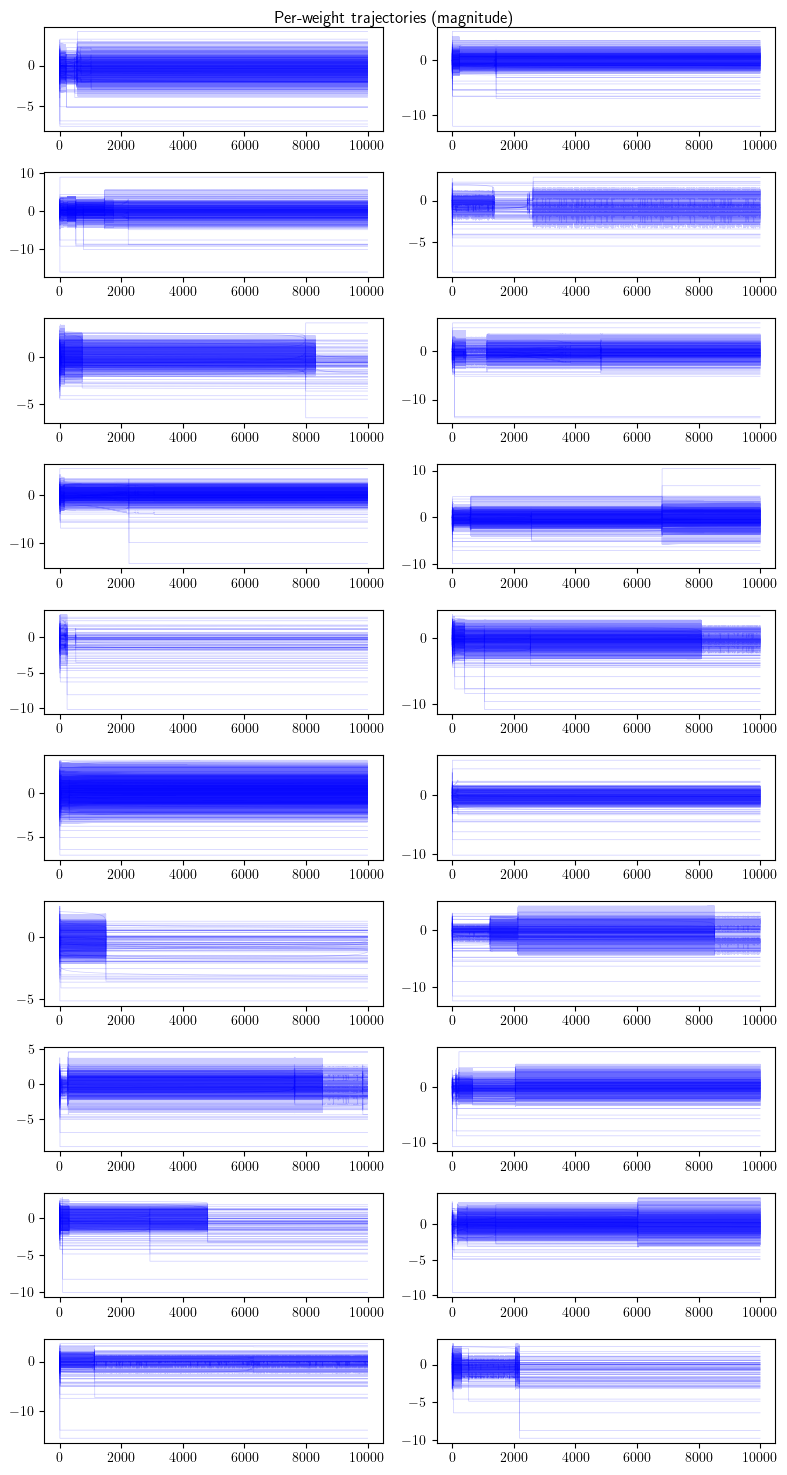

In [74]:
with h5py.File('results/chaotic.h5', 'r') as f :
    weights_ds = f['weights']
    loss_ds = f['loss']

    # i_eps = 10

    fig, axs = plt.subplots(10, 2, figsize=(8, 15))

    for i, ax in enumerate(axs.flatten()) :
        ws = weights_ds[i]
        ws = ws.reshape(ws.shape[0],-1)
        ax.plot(ws[:,~np.all(ws == 0, axis=0)], color='blue', alpha=0.2, lw=0.5)
    
    fig.suptitle("Per-weight trajectories (magnitude)")
    plt.tight_layout()
    plt.savefig('../report/figures/chaotic_weights_all.pdf')

(10000, 208)
(10000, 83)
(10000, 83)


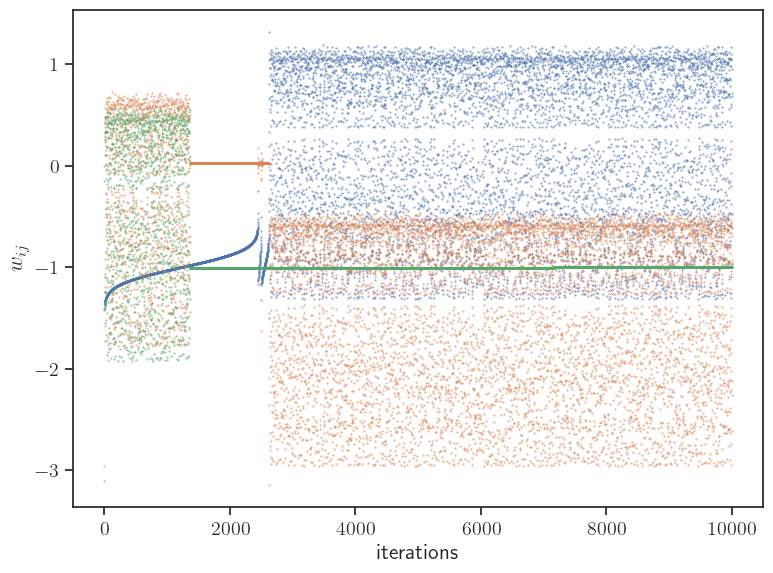

In [431]:
with h5py.File('results/chaotic.h5', 'r') as f :
    weights_ds = f['weights']
    loss_ds = f['loss']

    # i_eps = 10
    i_init = 3

    fig = plt.figure(figsize=(8, 6))
    ax = plt.gca()

    ws = weights_ds[i_init]
    ws = ws.reshape(ws.shape[0],-1)     # Flatten w.r.t. weights
    print(ws.shape)
    ws = ws[:,~np.all(ws == 0, axis=0)]     # Remove buffer weights
    print(ws.shape)
    # change_threshold = 15
    change_threshold = 10000
    ws_change = np.sum(np.abs(ws[1:,:] - ws[:-1,:]), axis=0)
    ws_plot = ws[:, ws_change > change_threshold]   # Extract trajectories based on threshold
    print(ws.shape)

    # Add weight with "flat" evolution
    w_idx = 77
    ws_plot = np.concatenate((ws_plot, ws[:, w_idx].reshape(-1, 1)), axis=1)
    
    ax.plot(ws_plot, '.', alpha=1, ms=0.7)
    # ax.set_title("Per-weight trajectories (magnitude)")
    ax.set_xlabel("iterations")
    ax.set_ylabel("$w_{ij}$")
    
    plt.tight_layout()
    # plt.savefig('../report/figures/chaotic_weights_individual.pdf')
    plt.savefig('../report/figures/chaotic_weights_individual.png', dpi=200, bbox_inches='tight')

(array([71, 72, 73, 77, 79, 80, 81, 82]),)


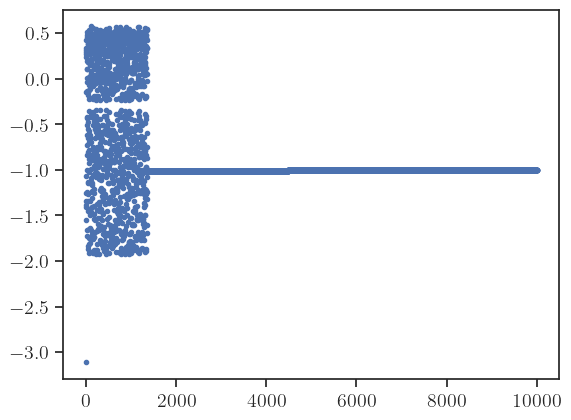

In [425]:
print(np.where(ws_change > 1000))

plt.plot(ws[:, 77], '.')

Text(0, 0.5, '$d_n$')

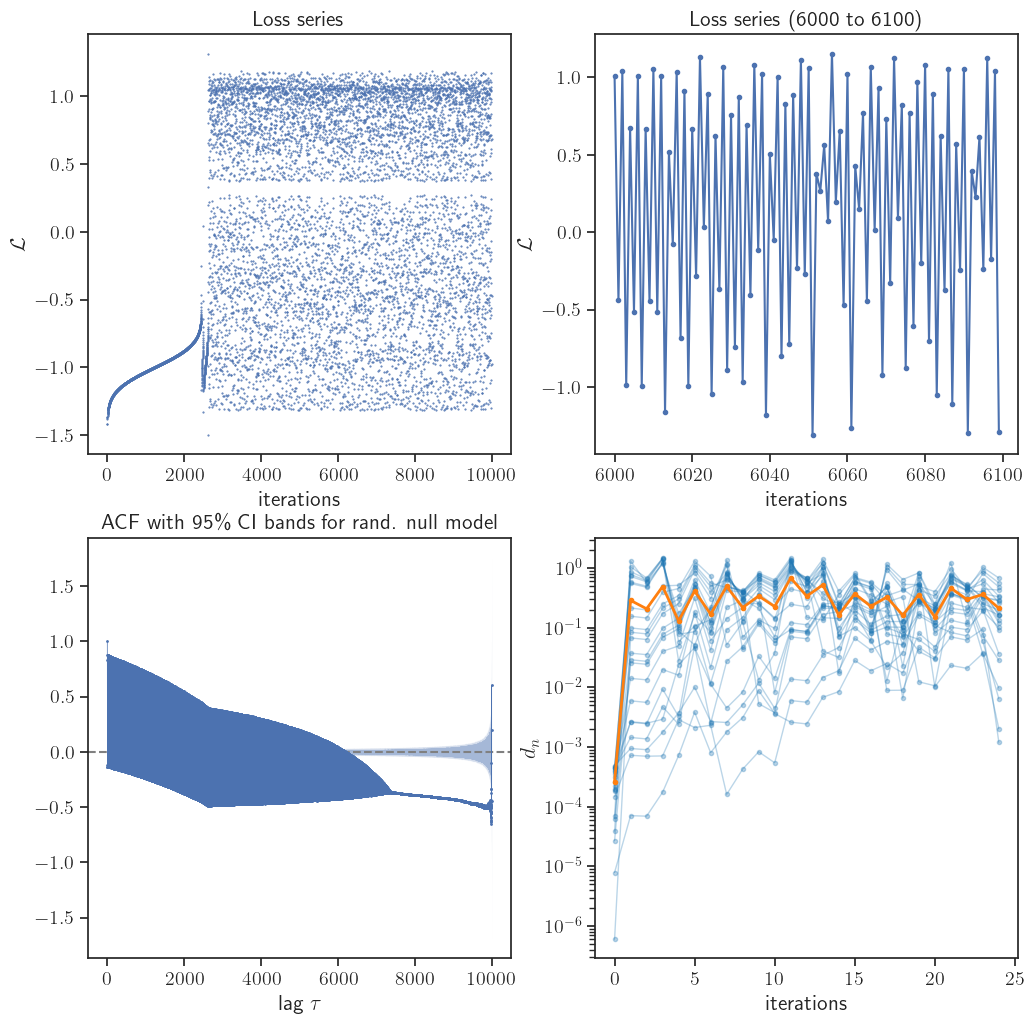

In [138]:
# Test chaosticity for single-trajectories
ws0 = ws[:,0]
ws0_norm = ws0 - np.mean(ws0)
# ws0_corr, ws0_ci = autocorr_ci(ws0_norm, n_shuffle=1000, CI=0.03)

# Plot autocorrelation and divergence

fig, axs = plt.subplots(2, 2, figsize=(12,12))
axs = axs.flatten()

axs[0].set_title("Loss series")
axs[0].plot(ws0, '.', ms=1)
axs[0].set_xlabel('iterations')
axs[0].set_ylabel('$\mathcal{L}$')

lim = 50
lim = 4000
lims = (6000, 6100)
axs[1].set_title(f'Loss series ({lims[0]} to {lims[1]})')
axs[1].plot(range(*lims), ws0[lims[0]:lims[1]], '.-')
axs[1].set_xlabel('iterations')
axs[1].set_ylabel('$\mathcal{L}$')

lim = 50
lim = 5000
lims = (9900, 10000)
lims = (0, 10000)
axs[2].set_title('ACF with 95\% CI bands for rand. null model')
axs[2].axhline(0, ls='--', color='gray')
axs[2].fill_between(range(*lims), ws0_ci[lims[0]:lims[1],0], ws0_ci[lims[0]:lims[1],1], alpha=0.5)
axs[2].plot(range(*lims), ws0_corr[lims[0]:lims[1]], '.-', ms=2, lw=0.5);
axs[2].set_xlabel('lag $\\tau$')



start = 3000
ws0 = ws0[start:]

rng = np.random.default_rng(1)
n_sample = 100
while True :
    p0s_idx = rng.integers(0, ws0.shape[0], n_sample)
    if len(np.unique(p0s_idx)) == n_sample : break

e = 5e-4
p1s_idx = []
ws0_idx = np.arange(len(ws0))
for p0 in p0s_idx :
    p1s_idx.append(ws0_idx[(ws0 < ws0[p0]+e) & (ws0 > ws0[p0]-e) & (ws0 != ws0[p0])])

trajectories = []
for i in range(n_sample) :
    p0_traj = ws0[p0s_idx[i]:]
    p1s_traj = []
    for p1 in p1s_idx[i] :
        p1s_traj.append(ws0[p1:])
    
    trajectories.append((p0_traj, p1s_traj))

p0_idx = 6
t1 = trajectories[p0_idx][0]
t2s = trajectories[p0_idx][1]

lim = 25
ds = np.zeros(lim)
for t2 in t2s :
    n_max = max(len(t1), len(t2))
    t1 = np.pad(t1, (0, n_max-len(t1)), mode='constant', constant_values=None)
    t2 = np.pad(t2, (0, n_max-len(t2)), mode='constant', constant_values=None)
    # distance = t1 - t2
    d = np.abs(t1 - t2)[:lim]
    ds += d
    axs[3].plot(d, '.-', lw=1, color='tab:blue', alpha=0.3)

axs[3].plot(ds/len(t2s), '.-', lw=2, color='tab:orange');
axs[3].set_yscale('log')
axs[3].set_xlabel("iterations")
axs[3].set_ylabel("$d_n$")

(array([22., 14., 15., 11.,  9.,  7., 10.,  4.,  2.,  3.,  0.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.  ,  1.15,  2.3 ,  3.45,  4.6 ,  5.75,  6.9 ,  8.05,  9.2 ,
        10.35, 11.5 , 12.65, 13.8 , 14.95, 16.1 , 17.25, 18.4 , 19.55,
        20.7 , 21.85, 23.  ]),
 <BarContainer object of 20 artists>)

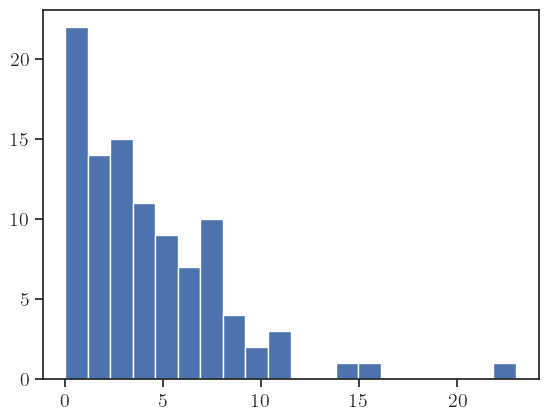

In [131]:
nt = []
for tup in trajectories :
    nt.append(len(tup[1]))  # number of nearby trajectories found for particular point
plt.hist(nt, bins=20)

### Other $\eta$

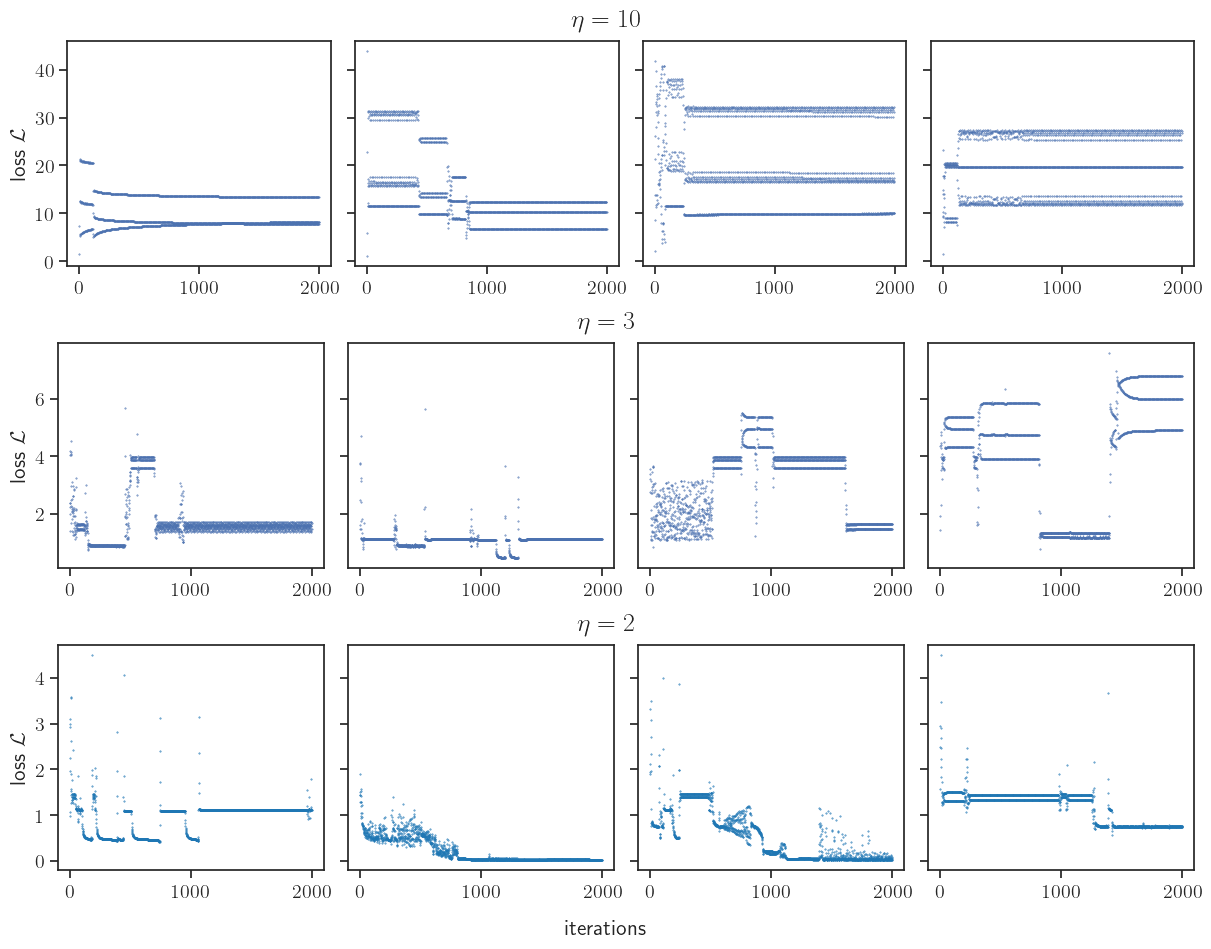

In [104]:
fig = plt.figure(layout='constrained', figsize=(12, 9))
subfigs = fig.subfigures(3, 1, wspace=0.07)

###

with open("results/chaotic_10.pkl", 'rb') as f : weights_ds = pickle.load(f)
with open("results/chaotic_10_loss.pkl", 'rb') as f : loss_ds = pickle.load(f)

max_iter = loss_ds.shape[1]

subfigs[0].suptitle("$\eta=10$")
axs = subfigs[0].subplots(1, 4, sharex=True, sharey=True)
init_idx = [0, 1, 8, 10]
for i, i_init in enumerate(init_idx) :
    axs[i].plot(range(max_iter), loss_ds[i_init].T, 'o', ms=0.4, color=colors[0]);
    # axs[i].set_xlabel("iteration")
axs[0].set_ylabel("loss $\mathcal{L}$")

###

with open("results/chaotic_3.pkl", 'rb') as f : weights_ds = pickle.load(f)
with open("results/chaotic_3_loss.pkl", 'rb') as f : loss_ds = pickle.load(f)

subfigs[1].suptitle("$\eta=3$")
axs = subfigs[1].subplots(1, 4, sharex=True, sharey=True)
init_idx = [0, 1, 9, 10]
for i, i_init in enumerate(init_idx) :
    axs[i].plot(range(max_iter), loss_ds[i_init].T, 'o', ms=0.4, color=colors[0]);
    # axs[i].set_xlabel("iteration")
axs[0].set_ylabel("loss $\mathcal{L}$")

###

with open("results/chaotic_2.pkl", 'rb') as f : weights_ds = pickle.load(f)
with open("results/chaotic_2_loss.pkl", 'rb') as f : loss_ds = pickle.load(f)

subfigs[2].suptitle("$\eta=2$")
axs = subfigs[2].subplots(1, 4, sharex=True, sharey=True)
init_idx = [0, 1, 3, 8]
for i, i_init in enumerate(init_idx) :
    axs[i].plot(range(max_iter), loss_ds[i_init].T, 'o', ms=0.4, color=[0]);
    # axs[i].set_xlabel("iteration")
axs[0].set_ylabel("loss $\mathcal{L}$")

subfigs[2].text(0.5, -0.1, 'iterations', ha='center')
# fig.add_subplot(111, frameon=False, zorder=100)
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# plt.xlabel("common X")

plt.savefig("../report/figures/chaotic_alt.pdf", bbox_inches='tight')

del weights_ds
del loss_ds

# Appendix — Full results

[1.e-15 1.e-14 1.e-13 1.e-12 1.e-11 1.e-10 1.e-09 1.e-08 1.e-07 1.e-06
 1.e-05 1.e-04 1.e-03 1.e-02]


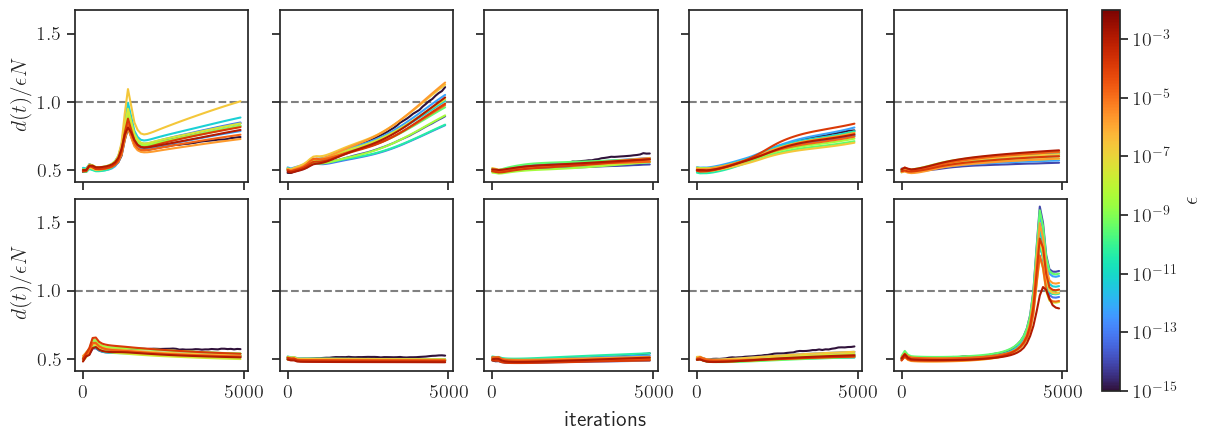

In [61]:
# Init perturb, normalized by epsilon
with h5py.File('results/epsilon_full.h5', 'r') as f :
    weights_ds = f['weights']

    n_init = f.attrs['n_init']
    n_pert = f.attrs['n_pert']
    # i_init = 0

    epsilons = f.attrs['epsilons']
    # eps_indices = [4, 8, 12, 16]
    eps_indices = range(3, len(epsilons)-5)
    print(epsilons[eps_indices])

    period = 100
    dists_all = iris_train.get_dists_dataset_frommat(weights_ds[:,:,:,::period,...])
    iter = np.arange(0, f.attrs['n_sample_points'], period)

norm_factors = 70 * epsilons    # number of neurons * pert radius = max pert distance

fig = plt.figure(figsize=(12,4), layout='constrained')
# fig.set_constrained_layout_pads(wspace=0.1)
subfigs = fig.subfigures(1, 2, wspace=None, width_ratios=[10, 1])
axs_plot = subfigs[0].subplots(2, 5, sharex=True, sharey=True)
axs_cbar = subfigs[1].subplots(1, 1)

axs = axs_plot.flatten()

cmap = mpl.colormaps['turbo']
norm = mpl.colors.LogNorm(epsilons[eps_indices[0]], epsilons[eps_indices[-1]])

for i_ax, ax in enumerate(axs) :
    for i, i_eps in enumerate(eps_indices) :
        d = dists_all[i_eps,i_ax]/norm_factors[i_eps]
        ax.plot(iter, np.mean(d.T, axis=1), color=cmap(i/len(eps_indices)), alpha=1, zorder=5)

    ax.axhline(1, ls='--', color='gray')
axs_plot[0,0].set_ylabel('$d(t)/\epsilon N$')
axs_plot[1,0].set_ylabel('$d(t)/\epsilon N$')

plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), cax=axs_cbar, label='$\epsilon$')
fig.text(0.5, -0.05, 'iterations', ha='center')
plt.savefig('../report/figures/epsilon_full_norm.pdf', bbox_inches='tight')

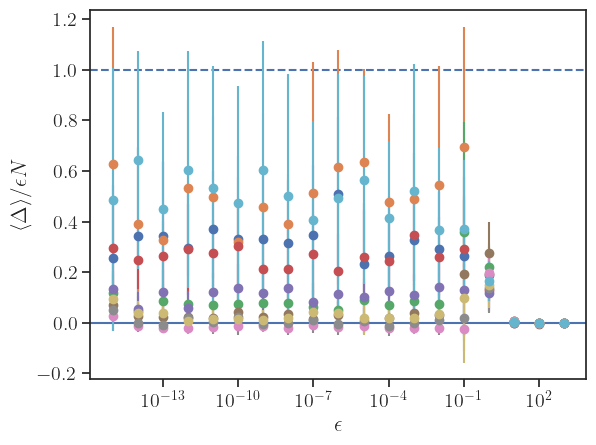

In [64]:
plt.axhline(0)
plt.axhline(1, ls='--')

for i_init in range(n_init) :
    # get average final dist
    dists_avg = np.mean(dists_all[3:, i_init, ...], axis=1)
    d_final = dists_avg[:,-1]
    dists_std = np.std(dists_all[3:, i_init, ...], axis=1)
    d_final_std = dists_std[:,-1]

    d_final = np.mean(dists_all[3:,i_init,:,-1,...] - dists_all[3:,i_init,:,0,...], axis=1)
    d_final_std = np.std(dists_all[3:,i_init,:,-1,...] - dists_all[3:,i_init,:,0,...], axis=1)

    # normalize and plot as function of delta / d0_exp
    d_final_norm = d_final / norm_factors[3:]
    d_final_std_norm = d_final_std / norm_factors[3:]

    plt.errorbar(epsilons[3:], d_final_norm, yerr=d_final_std_norm, fmt='o')
plt.xlabel('$\epsilon$')
plt.ylabel('$\langle\Delta\\rangle / \epsilon N$')
plt.xscale('log')
# plt.yscale('log')
# plt.title("Final distance relative to size of 'ball'")

[1.e-15 1.e-14 1.e-13 1.e-12 1.e-11 1.e-10 1.e-09 1.e-08 1.e-07 1.e-06
 1.e-05 1.e-04 1.e-03 1.e-02]


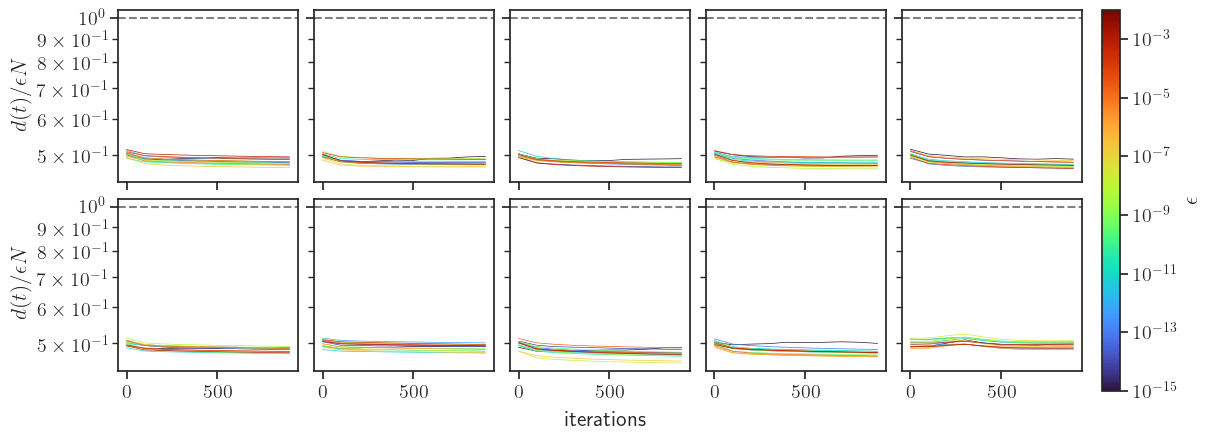

In [66]:
# Basin perturb, normalized by epsilon
with h5py.File('results/post_learn.h5', 'r') as f :
    weights_ds = f['weights']

    n_init = f.attrs['n_init']
    n_pert = f.attrs['n_pert']
    # i_init = 0

    epsilons = f.attrs['epsilons']
    # eps_indices = [4, 8, 12, 16]
    eps_indices = range(3, len(epsilons)-5)
    print(epsilons[eps_indices])

    period = 100
    dists_all = iris_train.get_dists_dataset_frommat(weights_ds[:,:,:,::period,...])
    iter = np.arange(0, f.attrs['n_sample_points'], period)

norm_factors = 70 * epsilons    # number of neurons * pert radius = max pert distance

fig = plt.figure(figsize=(12,4), layout='constrained')
# fig.set_constrained_layout_pads(wspace=0.1)
subfigs = fig.subfigures(1, 2, wspace=None, width_ratios=[10, 1])
axs_plot = subfigs[0].subplots(2, 5, sharex=True, sharey=True)
axs_cbar = subfigs[1].subplots(1, 1)

axs = axs_plot.flatten()

cmap = mpl.colormaps['turbo']
norm = mpl.colors.LogNorm(epsilons[eps_indices[0]], epsilons[eps_indices[-1]])

for i_ax, ax in enumerate(axs) :
    for i, i_eps in enumerate(eps_indices) :
        d = dists_all[i_eps,i_ax]/norm_factors[i_eps]
        ax.plot(iter, np.mean(d.T, axis=1), color=cmap(i/len(eps_indices)), alpha=1, zorder=5, lw=0.5)

    ax.axhline(1, ls='--', color='gray')
    ax.set_yscale('log')
axs_plot[0,0].set_ylabel('$d(t)/\epsilon N$')
axs_plot[1,0].set_ylabel('$d(t)/\epsilon N$')

plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), cax=axs_cbar, label='$\epsilon$')
fig.text(0.5, -0.05, 'iterations', ha='center')
plt.savefig('../report/figures/epsilon_post_learn_norm.pdf', bbox_inches='tight')

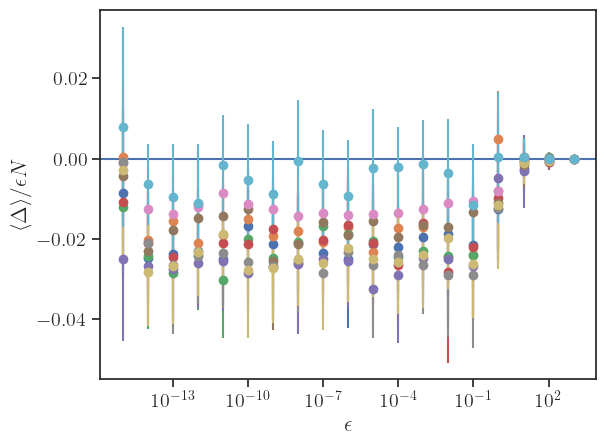

In [69]:
plt.axhline(0)
# plt.axhline(1, ls='--')

for i_init in range(n_init) :
    # get average final dist
    dists_avg = np.mean(dists_all[3:, i_init, ...], axis=1)
    d_final = dists_avg[:,-1]
    dists_std = np.std(dists_all[3:, i_init, ...], axis=1)
    d_final_std = dists_std[:,-1]

    d_final = np.mean(dists_all[3:,i_init,:,-1,...] - dists_all[3:,i_init,:,0,...], axis=1)
    d_final_std = np.std(dists_all[3:,i_init,:,-1,...] - dists_all[3:,i_init,:,0,...], axis=1)

    # normalize and plot as function of delta / d0_exp
    d_final_norm = d_final / norm_factors[3:]
    d_final_std_norm = d_final_std / norm_factors[3:]

    plt.errorbar(epsilons[3:], d_final_norm, yerr=d_final_std_norm, fmt='o')
plt.xlabel('$\epsilon$')
plt.ylabel('$\langle\Delta\\rangle / \epsilon N$')
plt.xscale('log')
# plt.yscale('log')
# plt.title("Final distance relative to size of 'ball'")